In [5]:
# !pip install torch==2.1.1 torchaudio torchvision tqdm==4.66.1 accelerate==0.24.1 biopython==1.81 numpy==1.26.2 pandas==2.1.3 \
# transformers==4.35.2 datasets==2.15.0 scikit-learn==1.3.2 umap-learn==0.5.5 sentencepiece==0.1.99 seaborn==0.13.0 scipy==1.11.4 \
# matplotlib==3.8.2 evaluate==0.4.1 deepspeed==0.12.3

In [6]:
# try with UMAP

In [1]:
import os.path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader

import re
import numpy as np
import pandas as pd
import copy

import transformers, datasets
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.t5.modeling_t5 import T5Config, T5PreTrainedModel, T5Stack
from transformers.utils.model_parallel_utils import assert_device_map, get_device_map
from transformers import T5EncoderModel, T5Tokenizer
from transformers import TrainingArguments, Trainer, set_seed

from evaluate import load
from datasets import Dataset

from tqdm import tqdm
import random

from scipy import stats
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
#!pip install umap-learn
import umap

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Torch version: ",torch.__version__)
print("Cuda version: ",torch.version.cuda)
print("Numpy version: ",np.__version__)
print("Pandas version: ",pd.__version__)
print("Transformers version: ",transformers.__version__)
print("Datasets version: ",datasets.__version__)

Torch version:  2.1.1+cu121
Cuda version:  12.1
Numpy version:  1.26.4
Pandas version:  2.2.2
Transformers version:  4.35.2
Datasets version:  2.19.1


In [3]:
from Bio import SeqIO
import pandas as pd

sequences = []

local_fasta_path = '../src/input_datasets/train_Pos_Neg_ST.fasta'

# Load FASTA file using Biopython
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

local_fasta_path = '../src/input_datasets/train_Pos_Neg_Y.fasta'

for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df.head(5)


,name,sequence,label
0,sp|P24928|RPB1_HUMAN%1775%1791,NYTPTSPNYSPTSPSYSPTSPSYSPTSPSYSPS,1
1,sp|P05787|K2C8_HUMAN%58%74,SGMGGITAVTVNQSLLSPLVLEVDPNIQAVRTQ,1
2,sp|Q14832|GRM3_HUMAN%829%845,QPQKNVVTHRLHLNRFSVSGTGTTYSQSSASTY,1
3,sp|P01106|MYC_HUMAN%46%62,SEDIWKKFELLPTPPLSPSRRSGLCSPSYVAVT,1
4,sp|Q92736|RYR2_HUMAN%2792%2808,TREGDSMALYNRTRRISQTSQVSVDAAHGYSPR,1


In [4]:
# Function to get the middle character
def get_middle_char(sequence):
    chars = list(sequence)
    middle_index = len(chars) // 2
    return chars[middle_index]

# Apply the function to get the middle characters
df['middle_char'] = df['sequence'].apply(get_middle_char)

In [11]:
# # Function to count 'S', 'T', 'Y' in a sequence
# def count_chars(sequence, char):
#     return sequence.count(char)

# # Count the occurrences of 'S', 'T', and 'Y' in the sequences
# df['count_S'] = df['middle_char'].apply(lambda seq: count_chars(seq, 'S'))
# df['count_T'] = df['middle_char'].apply(lambda seq: count_chars(seq, 'T'))
# df['count_Y'] = df['middle_char'].apply(lambda seq: count_chars(seq, 'Y'))

# # Sum the counts to get the total occurrences in the DataFrame
# total_S = df['count_S'].sum()
# total_T = df['count_T'].sum()
# total_Y = df['count_Y'].sum()

# print(f"Total number of 'S': {total_S}")
# print(f"Total number of 'T': {total_T}")
# print(f"Total number of 'Y': {total_Y}")

In [12]:
# # Group by label and sum the counts
# grouped_counts = df.groupby('label')[['count_S', 'count_T', 'count_Y']].sum().reset_index()

# # Display the grouped counts
# print(grouped_counts)

In [13]:
# Separate the DataFrame by middle character
df_S = df[df['middle_char'] == 'S']
df_T = df[df['middle_char'] == 'T']
df_Y = df[df['middle_char'] == 'Y']

# Separate each subset by label
df_S_0 = df_S[df_S['label'] == 0]
df_S_1 = df_S[df_S['label'] == 1]
df_T_0 = df_T[df_T['label'] == 0]
df_T_1 = df_T[df_T['label'] == 1]
df_Y_0 = df_Y[df_Y['label'] == 0]
df_Y_1 = df_Y[df_Y['label'] == 1]


In [14]:
from sklearn.utils import resample
# Desired number of samples per group
n_samples_S = 500
n_sampple_T = 300
n_sampple_Y = 200
# Perform stratified sampling
df_S_0_resampled = resample(df_S_0, replace=False, n_samples=n_samples_S, random_state=42)
df_S_1_resampled = resample(df_S_1, replace=False, n_samples=n_samples_S, random_state=42)
df_T_0_resampled = resample(df_T_0, replace=True, n_samples=n_sampple_T, random_state=42)
df_T_1_resampled = resample(df_T_1, replace=True, n_samples=n_sampple_T, random_state=42)
df_Y_0_resampled = resample(df_Y_0, replace=True, n_samples=n_sampple_Y, random_state=42)
df_Y_1_resampled = resample(df_Y_1, replace=True, n_samples=n_sampple_Y, random_state=42)



In [15]:
# Combine the resampled subsets
balanced_df = pd.concat([
    df_S_0_resampled, df_S_1_resampled,
    df_T_0_resampled, df_T_1_resampled,
    df_Y_0_resampled, df_Y_1_resampled
])

# Shuffle the combined DataFrame
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced DataFrame:")
print(balanced_df)


Balanced DataFrame:
                                name                           sequence  \
0       sp|O60841|IF2P_HUMAN%118%134  DKDSKSKKTAKPKVEMYSGSDDDDDFNKLPKKA   
1        sp|P28290|ITPI2_HUMAN%81%97  WLKDCRTPLGASLDEQSSSTLKGVLVRNGGSFE   
2      sp|Q6ZW31|SYDE1_HUMAN%206%222  LDSSVGGPGPAAGPGGTRSPRAGYLSDGDSPER   
3      sp|P19634|SL9A1_HUMAN%589%605  VESGGMGKIPSAVSTVSMQNIHPKSLPSERILP   
4      sp|P23443|KS6B1_HUMAN%454%470  GDFWGRGASASTANPQTPVEYPMETSGIEQMDV   
...                              ...                                ...   
1995  sp|Q9H4A3|WNK1_HUMAN%1741%1757  TTSGVKPGTAPSKPPLTKAPVLPVGTELPAGTL   
1996     sp|Q04690|NF1_MOUSE%451%467  VQGCGAHPAIRMAPSLTFKEKVTSLKFKEKPTD   
1997   sp|O00567|NOP56_HUMAN%503%519  FSKPKKKKSFSKEELMSSDLEETAGSTSIPKRK   
1998    sp|Q9UBW5|BIN2_HUMAN%422%438  ATASPRPSSGNIPSSPTASGGGSPTSPRASLGT   
1999    sp|Q14938|NFIX_HUMAN%358%374  RPGSPRATASALHFPSTSIIQQSSPYFTHPTIR   

      label middle_char  
0         1           Y  
1         0           S  
2

In [4]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
my_train, my_valid = train_test_split(
    balanced_df, 
    test_size=0.2, 
    random_state=42, 
    stratify=balanced_df[['label', 'middle_char']]
)

my_train=my_train[["sequence", "label"]]
my_valid=my_valid[["sequence","label"]]


# Print the first 5 rows of the training set
print("Training Set:")
print(my_train.shape)

# Print the first 5 rows of the validation set
print("\nValidation Set:")
print(my_valid.shape)

NameError: name 'balanced_df' is not defined

In [5]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
my_train, my_valid = train_test_split(df, test_size=0.2, random_state=42)

my_train=my_train[["sequence", "label"]]
my_valid=my_valid[["sequence","label"]]


# Print the first 5 rows of the training set
print("Training Set:")
print(my_train.shape)

# Print the first 5 rows of the validation set
print("\nValidation Set:")
print(my_valid.shape)

Training Set:
(1584, 2)

Validation Set:
(396, 2)


In [5]:
# Modifies an existing transformer and introduce the LoRA layers

class LoRAConfig:
    def __init__(self):
        self.lora_rank = 4
        self.lora_init_scale = 0.01
        self.lora_modules = ".*SelfAttention|.*EncDecAttention"
        self.lora_layers = "q|k|v|o"
        self.trainable_param_names = ".*layer_norm.*|.*lora_[ab].*"
        self.lora_scaling_rank = 1
        # lora_modules and lora_layers are speicified with regular expressions
        # see https://www.w3schools.com/python/python_regex.asp for reference
        
class LoRALinear(nn.Module):
    def __init__(self, linear_layer, rank, scaling_rank, init_scale):
        super().__init__()
        self.in_features = linear_layer.in_features
        self.out_features = linear_layer.out_features
        self.rank = rank
        self.scaling_rank = scaling_rank
        self.weight = linear_layer.weight
        self.bias = linear_layer.bias
        if self.rank > 0:
            self.lora_a = nn.Parameter(torch.randn(rank, linear_layer.in_features) * init_scale)
            if init_scale < 0:
                self.lora_b = nn.Parameter(torch.randn(linear_layer.out_features, rank) * init_scale)
            else:
                self.lora_b = nn.Parameter(torch.zeros(linear_layer.out_features, rank))
        if self.scaling_rank:
            self.multi_lora_a = nn.Parameter(
                torch.ones(self.scaling_rank, linear_layer.in_features)
                + torch.randn(self.scaling_rank, linear_layer.in_features) * init_scale
            )
            if init_scale < 0:
                self.multi_lora_b = nn.Parameter(
                    torch.ones(linear_layer.out_features, self.scaling_rank)
                    + torch.randn(linear_layer.out_features, self.scaling_rank) * init_scale
                )
            else:
                self.multi_lora_b = nn.Parameter(torch.ones(linear_layer.out_features, self.scaling_rank))

    def forward(self, input):
        if self.scaling_rank == 1 and self.rank == 0:
            # parsimonious implementation for ia3 and lora scaling
            if self.multi_lora_a.requires_grad:
                hidden = F.linear((input * self.multi_lora_a.flatten()), self.weight, self.bias)
            else:
                hidden = F.linear(input, self.weight, self.bias)
            if self.multi_lora_b.requires_grad:
                hidden = hidden * self.multi_lora_b.flatten()
            return hidden
        else:
            # general implementation for lora (adding and scaling)
            weight = self.weight
            if self.scaling_rank:
                weight = weight * torch.matmul(self.multi_lora_b, self.multi_lora_a) / self.scaling_rank
            if self.rank:
                weight = weight + torch.matmul(self.lora_b, self.lora_a) / self.rank
            return F.linear(input, weight, self.bias)

    def extra_repr(self):
        return "in_features={}, out_features={}, bias={}, rank={}, scaling_rank={}".format(
            self.in_features, self.out_features, self.bias is not None, self.rank, self.scaling_rank
        )


def modify_with_lora(transformer, config):
    for m_name, module in dict(transformer.named_modules()).items():
        if re.fullmatch(config.lora_modules, m_name):
            for c_name, layer in dict(module.named_children()).items():
                if re.fullmatch(config.lora_layers, c_name):
                    assert isinstance(
                        layer, nn.Linear
                    ), f"LoRA can only be applied to torch.nn.Linear, but {layer} is {type(layer)}."
                    setattr(
                        module,
                        c_name,
                        LoRALinear(layer, config.lora_rank, config.lora_scaling_rank, config.lora_init_scale),
                    )
    return transformer

In [6]:
class ClassConfig:
    def __init__(self, dropout=0.7, num_labels=2):
        self.dropout_rate = dropout
        self.num_labels = num_labels

class T5EncoderClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, class_config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(class_config.dropout_rate)
        self.out_proj = nn.Linear(config.hidden_size, class_config.num_labels)
        
        # Trainable emphasis factor
        self.emphasis_factor = nn.Parameter(torch.tensor(1.0))
        
    def forward(self, hidden_states):
        seq_length = hidden_states.size(1)
        middle_idx = seq_length // 2
        middle_embedding = hidden_states[:, middle_idx, :]

        # Apply trainable emphasis factor
        emphasized_middle_embedding = middle_embedding * self.emphasis_factor

        # Combine with the average embedding
        average_embedding = torch.mean(hidden_states, dim=1)
        combined_embedding = emphasized_middle_embedding + average_embedding

        x = self.dropout(combined_embedding)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        logits = self.out_proj(x)
        return logits

    # def forward(self, hidden_states):

    #     hidden_states =  torch.mean(hidden_states,dim=1)  # avg embedding

    #     hidden_states = self.dropout(hidden_states)
    #     hidden_states = self.dense(hidden_states)
    #     hidden_states = torch.tanh(hidden_states)
    #     hidden_states = self.dropout(hidden_states)
    #     hidden_states = self.out_proj(hidden_states)
    #     return hidden_states
    
    # def forward(self, hidden_states):
    #     # Original sequence length and middle index
    #     seq_length = hidden_states.size(1)
    #     middle_idx = seq_length // 2

    #     # Extract the middle embedding vector
    #     middle_embedding = hidden_states[:, middle_idx, :]

    #     # Amplify the influence of the middle embedding
    #     amplified_middle_embedding = middle_embedding * 2

    #     # Combine with average to retain context
    #     average_embedding = torch.mean(hidden_states, dim=1)
    #     combined_embedding = 0.5 * amplified_middle_embedding + 0.5 * average_embedding

    #     # Classification layers
    #     x = self.dropout(combined_embedding)
    #     x = self.dense(x)
    #     x = torch.tanh(x)
    #     x = self.dropout(x)
    #     logits = self.out_proj(x)
    #     return logits


class T5EncoderForSimpleSequenceClassification(T5PreTrainedModel):

    def __init__(self, config: T5Config, class_config):
        super().__init__(config)
        self.num_labels = class_config.num_labels
        self.config = config

        self.shared = nn.Embedding(config.vocab_size, config.d_model)

        encoder_config = copy.deepcopy(config)
        encoder_config.use_cache = False
        encoder_config.is_encoder_decoder = False
        self.encoder = T5Stack(encoder_config, self.shared)

        self.dropout = nn.Dropout(class_config.dropout_rate) 
        self.classifier = T5EncoderClassificationHead(config, class_config)

        # Initialize weights and apply final processing
        self.post_init()

        # Model parallel
        self.model_parallel = False
        self.device_map = None

    def parallelize(self, device_map=None):
        self.device_map = (
            get_device_map(len(self.encoder.block), range(torch.cuda.device_count()))
            if device_map is None
            else device_map
        )
        assert_device_map(self.device_map, len(self.encoder.block))
        self.encoder.parallelize(self.device_map)
        self.classifier = self.classifier.to(self.encoder.first_device)
        self.model_parallel = True

    def deparallelize(self):
        self.encoder.deparallelize()
        self.encoder = self.encoder.to("cpu")
        self.model_parallel = False
        self.device_map = None
        torch.cuda.empty_cache()

    def get_input_embeddings(self):
        return self.shared

    def set_input_embeddings(self, new_embeddings):
        self.shared = new_embeddings
        self.encoder.set_input_embeddings(new_embeddings)

    def get_encoder(self):
        return self.encoder

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=True,
            return_dict=return_dict,
        )

        hidden_states = outputs[0]
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [13]:
def PT5_classification_model(num_labels, dropout):
    # Load PT5 and tokenizer
    model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50", force_download=True)
    tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", force_download=True) 
    
    # Create new Classifier model with PT5 dimensions
    class_config=ClassConfig(num_labels=num_labels, dropout=dropout)
    class_model=T5EncoderForSimpleSequenceClassification(model.config,class_config)
    
    # Set encoder and embedding weights to checkpoint weights
    class_model.shared=model.shared
    class_model.encoder=model.encoder    
    
    # Delete the checkpoint model
    model=class_model
    del class_model
    
    # Print number of trainable parameters
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ProtT5_Classfier\nTrainable Parameter: "+ str(params))    
 
    # Add model modification lora
    config = LoRAConfig()
    
    # Add LoRA layers
    model = modify_with_lora(model, config)
    
    # Freeze Embeddings and Encoder (except LoRA)
    for (param_name, param) in model.shared.named_parameters():
                param.requires_grad = False
    for (param_name, param) in model.encoder.named_parameters():
                param.requires_grad = False       

    for (param_name, param) in model.named_parameters():
            if re.fullmatch(config.trainable_param_names, param_name):
                param.requires_grad = True

    # Print trainable Parameter          
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ProtT5_LoRA_Classfier\nTrainable Parameter: "+ str(params) + "\n")
    
    return model, tokenizer

In [8]:
# Deepspeed config for optimizer CPU offload

ds_config = {
    "fp16": {
        "enabled": "auto",
        "loss_scale": 0,
        "loss_scale_window": 1000,
        "initial_scale_power": 16,
        "hysteresis": 2,
        "min_loss_scale": 1
    },

    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": "auto",
            "betas": "auto",
            "eps": "auto",
            "weight_decay": "auto"
        }
    },

    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": "auto",
            "warmup_max_lr": "auto",
            "warmup_num_steps": "auto"
        }
    },

    "zero_optimization": {
        "stage": 2,
        "offload_optimizer": {
            "device": "cpu",
            "pin_memory": True
        },
        "allgather_partitions": True,
        "allgather_bucket_size": 2e8,
        "overlap_comm": True,
        "reduce_scatter": True,
        "reduce_bucket_size": 2e8,
        "contiguous_gradients": True
    },

    "gradient_accumulation_steps": "auto",
    "gradient_clipping": "auto",
    "steps_per_print": 2000,
    "train_batch_size": "auto",
    "train_micro_batch_size_per_gpu": "auto",
    "wall_clock_breakdown": False
}

In [9]:
from transformers import TrainerCallback, TrainerState, TrainerControl

class EarlyStoppingCallback(TrainerCallback):
    """Custom early stopping callback that can monitor loss or accuracy."""
    
    def __init__(self, metric_name='eval_loss', early_stopping_patience=3, minimize=True):
        """
        Args:
            metric_name (str): Metric to monitor, default 'eval_loss'.
            early_stopping_patience (int): Number of checks with no improvement after which training will be stopped.
            minimize (bool): Set to True if the metric should be minimized, False if it should be maximized.
        """
        self.metric_name = metric_name
        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_counter = 0
        self.minimize = minimize
        self.best_metric = float('inf') if minimize else float('-inf')
    
    def on_evaluate(self, args, state, control, **kwargs):
        current_metric = kwargs['metrics'][self.metric_name]
        
        if (self.minimize and current_metric < self.best_metric) or (not self.minimize and current_metric > self.best_metric):
            self.best_metric = current_metric
            self.early_stopping_counter = 0
        else:
            self.early_stopping_counter += 1
        
        if self.early_stopping_counter >= self.early_stopping_patience:
            control.should_training_stop = True
            print(f'Stopping early! No improvement in {self.metric_name} for {self.early_stopping_patience} evaluation steps.')


class MultiObjectiveEarlyStoppingCallback(TrainerCallback):
    def __init__(self, early_stopping_patience, min_delta=0.001):
        self.early_stopping_patience = early_stopping_patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.best_val_accuracy = float('-inf')
        self.wait = 0

    def on_evaluate(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        # Extract current validation loss and accuracy
        val_loss = kwargs['metrics']['eval_loss']
        val_accuracy = kwargs['metrics']['eval_accuracy']

        # Check if current loss and accuracy improved significantly
        loss_improved = (self.best_val_loss - val_loss) > self.min_delta
        accuracy_improved = (val_accuracy - self.best_val_accuracy) > self.min_delta

        if loss_improved or accuracy_improved:
            # Update best scores and reset wait time
            self.best_val_loss = min(self.best_val_loss, val_loss)
            self.best_val_accuracy = max(self.best_val_accuracy, val_accuracy)
            self.wait = 0
        else:
            # If no improvement, increment the wait counter
            self.wait += 1
            if self.wait >= self.early_stopping_patience:
                # If wait exceeds the patience, stop training
                control.should_training_stop = True
                print(f"Stopping early at epoch {state.epoch}: No improvement in loss or accuracy for {self.early_stopping_patience} evaluations.")
                
class MultiObjectiveEarlyStoppingAndSaveCallback(TrainerCallback):
    def __init__(self, early_stopping_patience, min_delta=0.001, output_dir='./model_output', filename='finetuned_model'):
        self.early_stopping_patience = early_stopping_patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.best_val_accuracy = float('-inf')
        self.wait = 0
        self.output_dir = output_dir
        self.filename = filename
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

    def on_evaluate(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        val_loss = kwargs['metrics']['eval_loss']
        val_accuracy = kwargs['metrics']['eval_accuracy']
        model = kwargs['model']

        loss_improved = (self.best_val_loss - val_loss) > self.min_delta
        accuracy_improved = (val_accuracy - self.best_val_accuracy) > self.min_delta

        if loss_improved or accuracy_improved:
            self.best_val_loss = min(self.best_val_loss, val_loss)
            self.best_val_accuracy = max(self.best_val_accuracy, val_accuracy)
            self.wait = 0
            # Save the model as the best so far
            self.save_finetuned_parameters(model, os.path.join(self.output_dir, self.filename))
            print(f"Saved improved model to {self.output_dir}/{self.filename}")
        else:
            self.wait += 1
            if self.wait >= self.early_stopping_patience:
                control.should_training_stop = True
                print(f"Stopping early at epoch {state.epoch}: No improvement in loss or accuracy for {self.early_stopping_patience} evaluations.")
                
    def save_finetuned_parameters(self, model, filepath):
        # Create a dictionary to hold the non-frozen parameters
        non_frozen_params = {n: p for n, p in model.named_parameters() if p.requires_grad}
        # Save only the finetuned parameters 
        torch.save(non_frozen_params, filepath)

In [10]:
from sklearn.metrics import accuracy_score
#!pip install seaborn
import seaborn as sns

# Set random seeds for reproducibility of your trainings run
def set_seeds(s):
    torch.manual_seed(s)
    np.random.seed(s)
    random.seed(s)
    set_seed(s)

# Dataset creation
def create_dataset(tokenizer,seqs,labels):
    tokenized = tokenizer(seqs, max_length=1024, padding=True, truncation=True)
    dataset = Dataset.from_dict(tokenized)
    dataset = dataset.add_column("labels", labels)

    return dataset

def apply_umap(embeddings, n_components=2, min_dist=0.01):
    umap_model = umap.UMAP(n_components=n_components)
    umap_embeddings = umap_model.fit_transform(embeddings)
    return umap_embeddings

def plot_umap(embeddings, labels):
    data = {"UMAP1": embeddings[:, 0], "UMAP2": embeddings[:, 1], "Label": labels}
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="UMAP1", y="UMAP2", hue="Label", data=df, palette={0: "blue", 1: "magenta"}, s=50, alpha=0.9)
    plt.title("UMAP Visualization of Embeddings")
    plt.savefig("../Plots/UMAP_Visualization_of_Embeddings_new.pdf")
    plt.show()
    
# Main training fuction
def train_per_protein(
        train_df,         #training data
        valid_df,         #validation data      
        weight_decay,
        warmup_pct,
        num_labels= 2,    #1 for regression, >1 for classification
    
        # effective training batch size is batch * accum
        # we recommend an effective batch size of 8 
        batch= 4,         #for training
        accum= 2,         #gradient accumulation
    
        val_batch = 16,   #batch size for evaluation
        epochs=1,       #training epochs
        lr= 3e-4,         #recommended learning rate
        seed= 42,         #random seed
        deepspeed=False,  #if gpu is large enough disable deepspeed for training speedup
        gpu= 1,
        dropout=0.5, #dropout rate
         #L2 weight regularization
        ):         #gpu selection (1 for first gpu)

    # Set gpu device
    os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu-1)
    
    # Set all random seeds
    set_seeds(seed)
    
    # load model
    model, tokenizer = PT5_classification_model(num_labels=num_labels, dropout=dropout)

    # Preprocess inputs
    # Replace uncommon AAs with "X"
    train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    valid_df["sequence"]=valid_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    # Add spaces between each amino acid for PT5 to correctly use them
    train_df['sequence']=train_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)
    valid_df['sequence']=valid_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)

    # Create Datasets
    train_set=create_dataset(tokenizer,list(train_df['sequence']),list(train_df['label']))
    valid_set=create_dataset(tokenizer,list(valid_df['sequence']),list(valid_df['label']))

    # Huggingface Trainer arguments
    total_steps = epochs * len(train_df) // batch
    warmup_steps = int(warmup_pct * total_steps)
     
    # Define TrainingArguments
    args = TrainingArguments(
        output_dir='./results',              # where to save the model
        evaluation_strategy='epoch',         # evaluation is done at the end of each epoch
        logging_strategy='epoch',
        save_strategy='no',
        learning_rate=lr,                    # initial learning rate
        per_device_train_batch_size=batch,   # batch size per device
        gradient_accumulation_steps=accum,   # gradient accumulation steps
        num_train_epochs=epochs,             # number of epochs to train
        weight_decay=weight_decay,           # L2 weight regularization
        warmup_steps=warmup_steps,           # 10% of total steps
        load_best_model_at_end=False,         # load the best model at the end of training
        seed=seed,                           # random seed
        push_to_hub=False,                   # if you want to push model to the hub (Hugging Face Model Hub)
        logging_dir='./logs',
    )
    # metric_for_best_model='eval_loss|accuracy'

    # Metric definition for validation data
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred.predictions, eval_pred.label_ids
        # Check if predictions have the expected shape
        if isinstance(predictions, tuple):
            predictions = predictions[0]
        if predictions.ndim > 1 and predictions.shape[1] > 1:
            predictions = np.argmax(predictions, axis=1)
        # Now, compute the metric (e.g., accuracy)
        accuracy = accuracy_score(labels, predictions)
        
        # Return the metric(s) as a dictionary
        return {"accuracy": accuracy}
    
    # For minimizing loss
    early_stopping_loss = EarlyStoppingCallback(metric_name='eval_loss', early_stopping_patience=3, minimize=True)

    # For maximizing accuracy
    early_stopping_accuracy = EarlyStoppingCallback(metric_name='eval_accuracy', early_stopping_patience=3, minimize=False)
    # Trainer          
    trainer = Trainer(
        model,
        args,
        train_dataset=train_set,
        eval_dataset=valid_set,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[MultiObjectiveEarlyStoppingAndSaveCallback(
            early_stopping_patience=3,
            min_delta=0.001,
            output_dir='./model_output',
            filename='finetuned_model_ST.pth'
        )],
    )    

    def get_embeddings(model, tokenizer, sequences, batch_size=32, device="cuda"):
        embeddings = []
        model = model.to(device)
        model.eval()
    
        # Iterate over the sequences in batches
        for i in range(0, len(sequences), batch_size):
            # Extract a batch of sequences
            batch = sequences[i:i + batch_size]
    
            # Tokenize the batch using the specified tokenizer and convert to PyTorch tensors
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    
            with torch.no_grad():
                # Forward pass through the model to obtain outputs
                outputs = model(**inputs)
    
            # Extract hidden states from the second-to-last layer (penultimate layer)
            hidden_states = outputs.hidden_states[-2].detach().cpu().numpy()
    
            # Take the embeddings from the second-to-last layer
            embeddings_from_layer = hidden_states[:, 0, :]
    
            # Extend the list with the generated embeddings
            embeddings.extend(embeddings_from_layer)
    
            print(f"Batch {i // batch_size + 1}, Second-to-Last Layer Embeddings Shape: {embeddings_from_layer.shape}")
    
        return np.array(embeddings)

        
    # Train model
    trainer.train()

    # Get the best model
    # model = trainer.model
    # Ensure the best model is loaded
    best_model_path = os.path.join('./model_output', 'finetuned_model_ST.pth')
    if os.path.exists(best_model_path):
        state_dict = torch.load(best_model_path)
        model.load_state_dict(state_dict, strict=False)
        print(f"Loaded best model from {best_model_path}")
        
    # Evaluate the best model
    eval_results = trainer.evaluate()
    print(eval_results)
    
    # Print the current learning rate
    # current_lr = trainer.optimizer.param_groups[0]['lr']
    # print(f"Current learning rate: {current_lr}")
    
    valid_sequences = list(valid_df['sequence'])
    valid_embeddings = get_embeddings(model, tokenizer, valid_sequences)

    # Apply UMAP for dimensionality reduction
    umap_embeddings = apply_umap(valid_embeddings)

    # Plot UMAP embeddings
    labels = list(valid_df['label'])
    plot_umap(umap_embeddings, labels)

    return tokenizer, model, trainer.state.log_history


In [23]:
# %rm ST_dephos.sqlite3

[I 2024-05-29 14:43:54,287] Trial 11 finished with values: [0.8493158221244812, 0.84] and parameters: {'lr': 0.0024599657137391855, 'batch': 2, 'accum': 2, 'dropout_rate': 0.10972788942948437, 'weight_decay': 0.0001706839835573477, 'warmup_pct': 0.14523232526557664}. 


In [24]:
# torch.cuda.empty_cache()

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.600900,0.538260,0.739899
2,0.539800,0.629755,0.765152
3,0.542900,0.695803,0.719697
4,0.511300,0.610335,0.674242
5,0.559200,0.701322,0.765152


Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_ST.pth


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.629754900932312, 'eval_accuracy': 0.7651515151515151, 'eval_runtime': 5.5628, 'eval_samples_per_second': 71.187, 'eval_steps_per_second': 8.988, 'epoch': 5.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 3, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 4, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 5, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 6, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 7, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 8, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 9, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 10, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 11, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 12, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 13, Second-to-Last Layer 

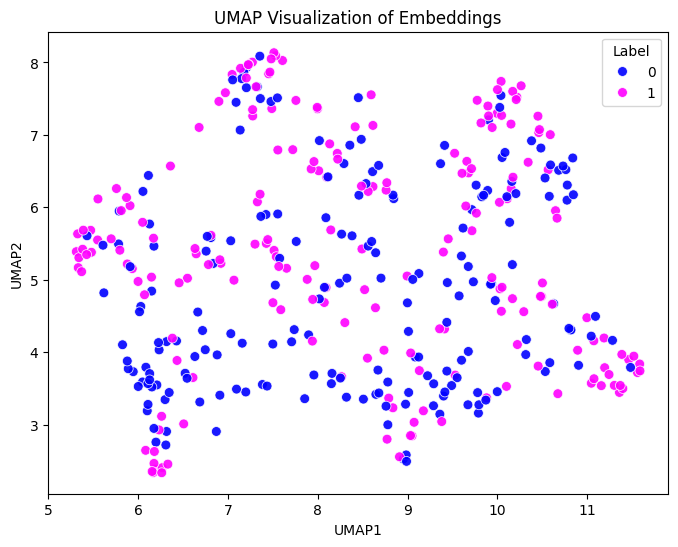

In [12]:
tokenizer, model, history = train_per_protein(my_train, my_valid, num_labels=2, batch=2, accum=2, epochs=20, seed=42, lr=0.0024599657137391855, dropout=0.10972788942948437, weight_decay=0.0001706839835573477, warmup_pct=0.14523232526557664)

[I 2024-05-29 13:08:48,499] A new study created in RDB with name: all_dephos
/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.691400,0.544058,0.737500
2,0.813200,0.554377,0.717500
3,0.828700,0.600564,0.690000
4,0.667500,0.547486,0.745000
5,0.519200,0.470128,0.770000


Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Loaded best model from ./model_output/finetuned_model_ST.pth


{'eval_loss': 0.4701276123523712, 'eval_accuracy': 0.77, 'eval_runtime': 5.5934, 'eval_samples_per_second': 71.513, 'eval_steps_per_second': 8.939, 'epoch': 5.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 3, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 4, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 5, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 6, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 7, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 8, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 9, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 10, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 11, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 12, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 13, Second-to-Last Layer Embeddings Shape: (16, 1024)


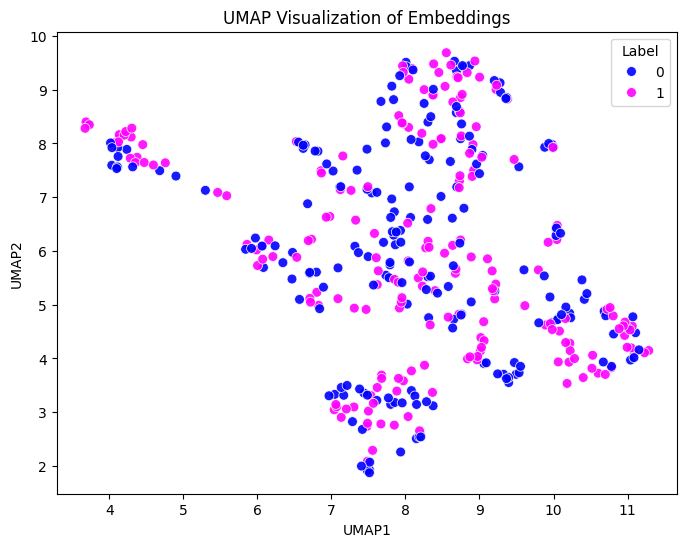

[I 2024-05-29 13:15:24,744] Trial 0 finished with values: [0.4701276123523712, 0.77] and parameters: {'lr': 0.0038492754648739446, 'batch': 4, 'accum': 2, 'dropout_rate': 0.8358014937808215, 'weight_decay': 0.0004982119001690409, 'warmup_pct': 0.16654108267386472}. 


History:  [{'loss': 0.6914, 'learning_rate': 0.002311877156080447, 'epoch': 1.0, 'step': 200}, {'eval_loss': 0.5440576076507568, 'eval_accuracy': 0.7375, 'eval_runtime': 6.0106, 'eval_samples_per_second': 66.549, 'eval_steps_per_second': 8.319, 'epoch': 1.0, 'step': 200}, {'loss': 0.8132, 'learning_rate': 0.003462616610081509, 'epoch': 2.0, 'step': 400}, {'eval_loss': 0.5543768405914307, 'eval_accuracy': 0.7175, 'eval_runtime': 5.5982, 'eval_samples_per_second': 71.451, 'eval_steps_per_second': 8.931, 'epoch': 2.0, 'step': 400}, {'loss': 0.8287, 'learning_rate': 0.002308411073387673, 'epoch': 3.0, 'step': 600}, {'eval_loss': 0.6005639433860779, 'eval_accuracy': 0.69, 'eval_runtime': 5.6038, 'eval_samples_per_second': 71.38, 'eval_steps_per_second': 8.922, 'epoch': 3.0, 'step': 600}, {'loss': 0.6675, 'learning_rate': 0.0011542055366938365, 'epoch': 4.0, 'step': 800}, {'eval_loss': 0.547485888004303, 'eval_accuracy': 0.745, 'eval_runtime': 5.5931, 'eval_samples_per_second': 71.516, 'eval

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.606600,0.537863,0.740000
2,0.485400,0.521051,0.755000
3,0.436500,0.502058,0.760000
4,0.408400,0.495201,0.757500
5,0.403600,0.493960,0.757500


Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Loaded best model from ./model_output/finetuned_model_ST.pth


{'eval_loss': 0.4939599633216858, 'eval_accuracy': 0.7575, 'eval_runtime': 5.4162, 'eval_samples_per_second': 73.852, 'eval_steps_per_second': 9.232, 'epoch': 5.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 3, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 4, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 5, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 6, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 7, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 8, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 9, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 10, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 11, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 12, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 13, Second-to-Last Layer Embeddings Shape: (16, 1024)


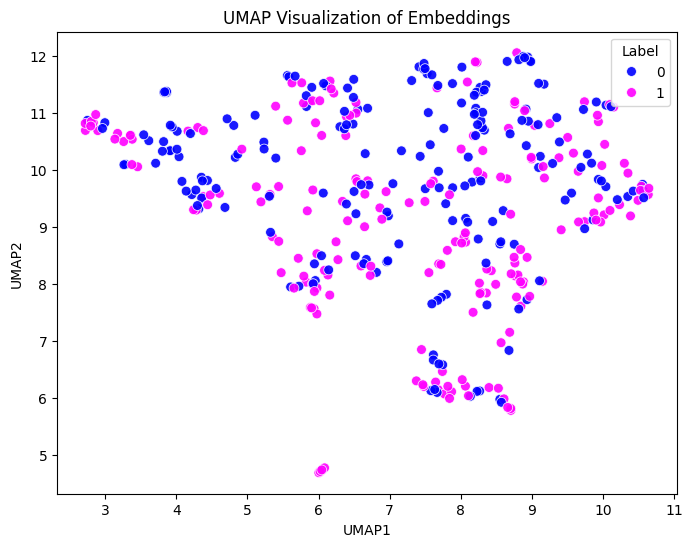

[I 2024-05-29 13:21:52,683] Trial 1 finished with values: [0.4939599633216858, 0.7575] and parameters: {'lr': 0.00013302634912207005, 'batch': 4, 'accum': 2, 'dropout_rate': 0.4365415603560969, 'weight_decay': 0.0006468545682635823, 'warmup_pct': 0.048913975735918463}. 


History:  [{'loss': 0.6066, 'learning_rate': 0.00011785280099408198, 'epoch': 1.0, 'step': 200}, {'eval_loss': 0.5378630757331848, 'eval_accuracy': 0.74, 'eval_runtime': 5.9486, 'eval_samples_per_second': 67.243, 'eval_steps_per_second': 8.405, 'epoch': 1.0, 'step': 200}, {'loss': 0.4854, 'learning_rate': 8.83896007455615e-05, 'epoch': 2.0, 'step': 400}, {'eval_loss': 0.521051287651062, 'eval_accuracy': 0.755, 'eval_runtime': 5.5183, 'eval_samples_per_second': 72.487, 'eval_steps_per_second': 9.061, 'epoch': 2.0, 'step': 400}, {'loss': 0.4365, 'learning_rate': 5.892640049704099e-05, 'epoch': 3.0, 'step': 600}, {'eval_loss': 0.5020583868026733, 'eval_accuracy': 0.76, 'eval_runtime': 5.4094, 'eval_samples_per_second': 73.946, 'eval_steps_per_second': 9.243, 'epoch': 3.0, 'step': 600}, {'loss': 0.4084, 'learning_rate': 2.9463200248520496e-05, 'epoch': 4.0, 'step': 800}, {'eval_loss': 0.49520087242126465, 'eval_accuracy': 0.7575, 'eval_runtime': 5.4127, 'eval_samples_per_second': 73.9, 'ev

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.686400,0.664651,0.650000
2,0.636100,0.605927,0.727500
3,0.561400,0.551924,0.745000
4,0.502100,0.520174,0.767500
5,0.455300,0.527125,0.780000


Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Loaded best model from ./model_output/finetuned_model_ST.pth


{'eval_loss': 0.5271251201629639, 'eval_accuracy': 0.78, 'eval_runtime': 5.4203, 'eval_samples_per_second': 73.797, 'eval_steps_per_second': 9.225, 'epoch': 5.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 3, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 4, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 5, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 6, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 7, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 8, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 9, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 10, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 11, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 12, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 13, Second-to-Last Layer Embeddings Shape: (16, 1024)


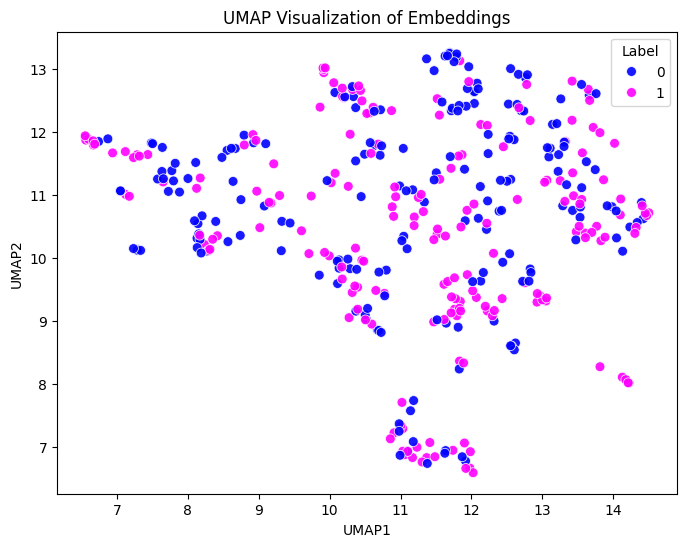

[I 2024-05-29 13:37:08,779] Trial 2 finished with values: [0.5271251201629639, 0.78] and parameters: {'lr': 5.097555530468175e-05, 'batch': 1, 'accum': 4, 'dropout_rate': 0.3715709075820146, 'weight_decay': 5.0100326855972136e-05, 'warmup_pct': 0.2569993708977304}. 


History:  [{'loss': 0.6864, 'learning_rate': 9.922249207723943e-06, 'epoch': 1.0, 'step': 400}, {'eval_loss': 0.664650559425354, 'eval_accuracy': 0.65, 'eval_runtime': 5.9083, 'eval_samples_per_second': 67.701, 'eval_steps_per_second': 8.463, 'epoch': 1.0, 'step': 400}, {'loss': 0.6361, 'learning_rate': 1.9844498415447886e-05, 'epoch': 2.0, 'step': 800}, {'eval_loss': 0.6059273481369019, 'eval_accuracy': 0.7275, 'eval_runtime': 5.4408, 'eval_samples_per_second': 73.518, 'eval_steps_per_second': 9.19, 'epoch': 2.0, 'step': 800}, {'loss': 0.5614, 'learning_rate': 2.9766747623171825e-05, 'epoch': 3.0, 'step': 1200}, {'eval_loss': 0.5519242286682129, 'eval_accuracy': 0.745, 'eval_runtime': 5.4262, 'eval_samples_per_second': 73.716, 'eval_steps_per_second': 9.215, 'epoch': 3.0, 'step': 1200}, {'loss': 0.5021, 'learning_rate': 3.968899683089577e-05, 'epoch': 4.0, 'step': 1600}, {'eval_loss': 0.5201744437217712, 'eval_accuracy': 0.7675, 'eval_runtime': 5.5055, 'eval_samples_per_second': 72.65

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.707600,0.687845,0.550000
2,0.689200,0.670293,0.615000
3,0.664900,0.658944,0.667500
4,0.660300,0.652810,0.677500
5,0.657800,0.650928,0.680000


Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Loaded best model from ./model_output/finetuned_model_ST.pth


{'eval_loss': 0.6509279012680054, 'eval_accuracy': 0.68, 'eval_runtime': 5.4291, 'eval_samples_per_second': 73.676, 'eval_steps_per_second': 9.21, 'epoch': 5.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 3, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 4, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 5, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 6, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 7, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 8, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 9, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 10, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 11, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 12, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 13, Second-to-Last Layer Embeddings Shape: (16, 1024)


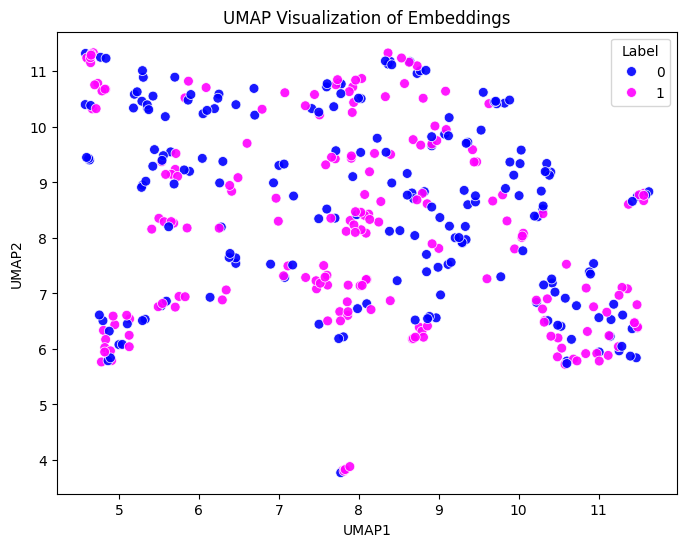

[I 2024-05-29 13:42:04,577] Trial 3 finished with values: [0.6509279012680054, 0.68] and parameters: {'lr': 1.0780617596821747e-05, 'batch': 8, 'accum': 2, 'dropout_rate': 0.6314657682190356, 'weight_decay': 4.7823725914420635e-05, 'warmup_pct': 0.12594047201021946}. 


History:  [{'loss': 0.7076, 'learning_rate': 8.624494077457398e-06, 'epoch': 1.0, 'step': 100}, {'eval_loss': 0.6878452897071838, 'eval_accuracy': 0.55, 'eval_runtime': 5.9186, 'eval_samples_per_second': 67.583, 'eval_steps_per_second': 8.448, 'epoch': 1.0, 'step': 100}, {'loss': 0.6892, 'learning_rate': 8.624494077457398e-06, 'epoch': 2.0, 'step': 200}, {'eval_loss': 0.6702926754951477, 'eval_accuracy': 0.615, 'eval_runtime': 5.4868, 'eval_samples_per_second': 72.902, 'eval_steps_per_second': 9.113, 'epoch': 2.0, 'step': 200}, {'loss': 0.6649, 'learning_rate': 5.749662718304932e-06, 'epoch': 3.0, 'step': 300}, {'eval_loss': 0.658943772315979, 'eval_accuracy': 0.6675, 'eval_runtime': 5.4167, 'eval_samples_per_second': 73.846, 'eval_steps_per_second': 9.231, 'epoch': 3.0, 'step': 300}, {'loss': 0.6603, 'learning_rate': 2.874831359152466e-06, 'epoch': 4.0, 'step': 400}, {'eval_loss': 0.652810275554657, 'eval_accuracy': 0.6775, 'eval_runtime': 5.4122, 'eval_samples_per_second': 73.907, 'e

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.640900,0.598586,0.717500
2,0.665600,0.633775,0.750000
3,0.578100,0.549929,0.742500
4,0.416800,0.521069,0.795000
5,0.273400,0.543048,0.815000


Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Loaded best model from ./model_output/finetuned_model_ST.pth


{'eval_loss': 0.5430476665496826, 'eval_accuracy': 0.815, 'eval_runtime': 5.4165, 'eval_samples_per_second': 73.849, 'eval_steps_per_second': 9.231, 'epoch': 5.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 3, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 4, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 5, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 6, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 7, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 8, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 9, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 10, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 11, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 12, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 13, Second-to-Last Layer Embeddings Shape: (16, 1024)


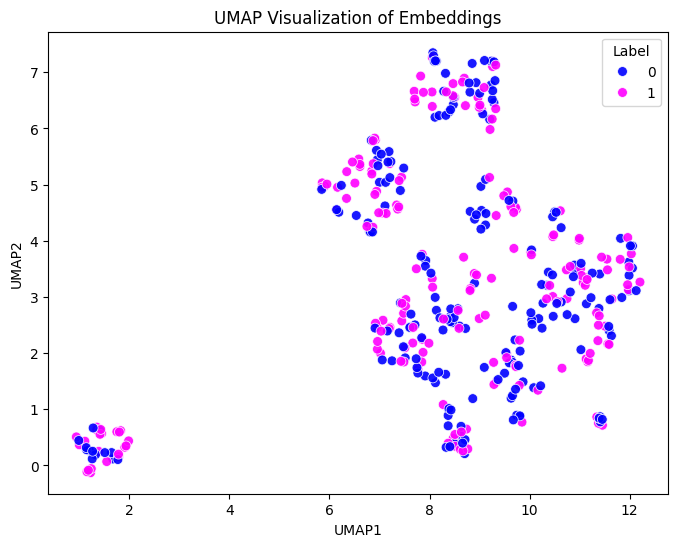

[I 2024-05-29 13:48:30,659] Trial 4 finished with values: [0.5430476665496826, 0.815] and parameters: {'lr': 0.004214177386051952, 'batch': 4, 'accum': 2, 'dropout_rate': 0.25818940311468785, 'weight_decay': 0.0008074788967055566, 'warmup_pct': 0.05406327393470831}. 


History:  [{'loss': 0.6409, 'learning_rate': 0.0037795312879389704, 'epoch': 1.0, 'step': 200}, {'eval_loss': 0.5985859632492065, 'eval_accuracy': 0.7175, 'eval_runtime': 5.9186, 'eval_samples_per_second': 67.583, 'eval_steps_per_second': 8.448, 'epoch': 1.0, 'step': 200}, {'loss': 0.6656, 'learning_rate': 0.0028346484659542283, 'epoch': 2.0, 'step': 400}, {'eval_loss': 0.6337752342224121, 'eval_accuracy': 0.75, 'eval_runtime': 5.4992, 'eval_samples_per_second': 72.738, 'eval_steps_per_second': 9.092, 'epoch': 2.0, 'step': 400}, {'loss': 0.5781, 'learning_rate': 0.0018897656439694852, 'epoch': 3.0, 'step': 600}, {'eval_loss': 0.5499292612075806, 'eval_accuracy': 0.7425, 'eval_runtime': 5.4316, 'eval_samples_per_second': 73.643, 'eval_steps_per_second': 9.205, 'epoch': 3.0, 'step': 600}, {'loss': 0.4168, 'learning_rate': 0.0009448828219847426, 'epoch': 4.0, 'step': 800}, {'eval_loss': 0.521069347858429, 'eval_accuracy': 0.795, 'eval_runtime': 5.4164, 'eval_samples_per_second': 73.85, 'e

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.640000,0.568006,0.730000
2,0.501600,0.511799,0.742500
3,0.422300,0.500829,0.780000
4,0.361100,0.452619,0.792500
5,0.332200,0.470896,0.790000


Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Loaded best model from ./model_output/finetuned_model_ST.pth


{'eval_loss': 0.4526187777519226, 'eval_accuracy': 0.7925, 'eval_runtime': 5.4147, 'eval_samples_per_second': 73.874, 'eval_steps_per_second': 9.234, 'epoch': 5.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 3, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 4, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 5, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 6, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 7, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 8, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 9, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 10, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 11, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 12, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 13, Second-to-Last Layer Embeddings Shape: (16, 1024)


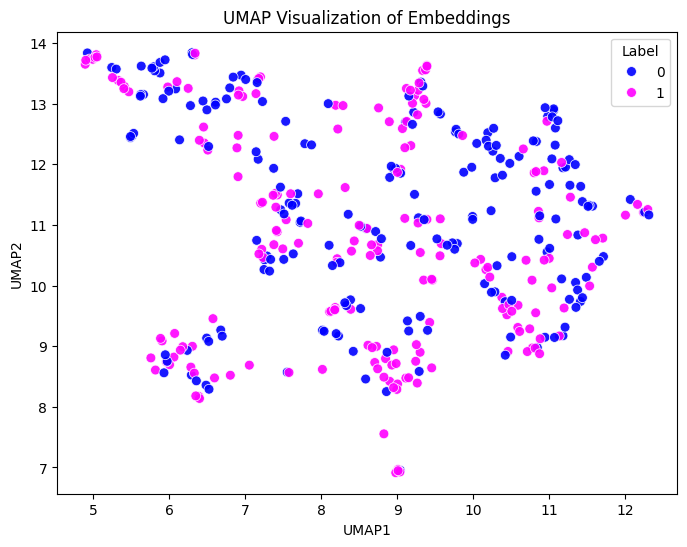

[I 2024-05-29 13:53:27,573] Trial 5 finished with values: [0.4526187777519226, 0.7925] and parameters: {'lr': 0.0003174284142040708, 'batch': 8, 'accum': 2, 'dropout_rate': 0.3245191599908862, 'weight_decay': 0.00010901914753941822, 'warmup_pct': 0.2143413598843849}. 


History:  [{'loss': 0.64, 'learning_rate': 0.00014833103467479944, 'epoch': 1.0, 'step': 100}, {'eval_loss': 0.5680055022239685, 'eval_accuracy': 0.73, 'eval_runtime': 5.923, 'eval_samples_per_second': 67.534, 'eval_steps_per_second': 8.442, 'epoch': 1.0, 'step': 100}, {'loss': 0.5016, 'learning_rate': 0.00029666206934959887, 'epoch': 2.0, 'step': 200}, {'eval_loss': 0.5117988586425781, 'eval_accuracy': 0.7425, 'eval_runtime': 5.4125, 'eval_samples_per_second': 73.903, 'eval_steps_per_second': 9.238, 'epoch': 2.0, 'step': 200}, {'loss': 0.4223, 'learning_rate': 0.00022197791203081873, 'epoch': 3.0, 'step': 300}, {'eval_loss': 0.5008294582366943, 'eval_accuracy': 0.78, 'eval_runtime': 5.4227, 'eval_samples_per_second': 73.764, 'eval_steps_per_second': 9.22, 'epoch': 3.0, 'step': 300}, {'loss': 0.3611, 'learning_rate': 0.00011098895601540936, 'epoch': 4.0, 'step': 400}, {'eval_loss': 0.4526187777519226, 'eval_accuracy': 0.7925, 'eval_runtime': 5.4148, 'eval_samples_per_second': 73.872, '

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.866900,0.684204,0.555000
2,0.836700,0.653269,0.602500
3,0.738600,0.662918,0.617500
4,0.719500,0.647721,0.637500
5,0.670400,0.624870,0.670000


Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Loaded best model from ./model_output/finetuned_model_ST.pth


{'eval_loss': 0.6248695254325867, 'eval_accuracy': 0.67, 'eval_runtime': 5.4155, 'eval_samples_per_second': 73.861, 'eval_steps_per_second': 9.233, 'epoch': 5.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 3, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 4, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 5, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 6, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 7, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 8, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 9, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 10, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 11, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 12, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 13, Second-to-Last Layer Embeddings Shape: (16, 1024)


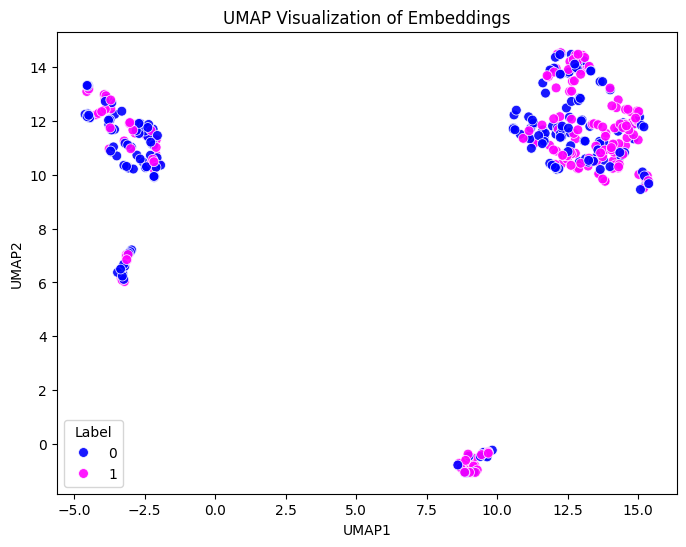

[I 2024-05-29 13:59:49,884] Trial 6 finished with values: [0.6248695254325867, 0.67] and parameters: {'lr': 0.008129843026205948, 'batch': 4, 'accum': 4, 'dropout_rate': 0.5392190804717986, 'weight_decay': 7.008520447523114e-05, 'warmup_pct': 0.017291378849764512}. 


History:  [{'loss': 0.8669, 'learning_rate': 0.006978406031078068, 'epoch': 1.0, 'step': 100}, {'eval_loss': 0.6842043995857239, 'eval_accuracy': 0.555, 'eval_runtime': 5.9116, 'eval_samples_per_second': 67.663, 'eval_steps_per_second': 8.458, 'epoch': 1.0, 'step': 100}, {'loss': 0.8367, 'learning_rate': 0.005233804523308551, 'epoch': 2.0, 'step': 200}, {'eval_loss': 0.6532690525054932, 'eval_accuracy': 0.6025, 'eval_runtime': 5.4968, 'eval_samples_per_second': 72.77, 'eval_steps_per_second': 9.096, 'epoch': 2.0, 'step': 200}, {'loss': 0.7386, 'learning_rate': 0.003489203015539034, 'epoch': 3.0, 'step': 300}, {'eval_loss': 0.6629176139831543, 'eval_accuracy': 0.6175, 'eval_runtime': 5.4239, 'eval_samples_per_second': 73.747, 'eval_steps_per_second': 9.218, 'epoch': 3.0, 'step': 300}, {'loss': 0.7195, 'learning_rate': 0.001744601507769517, 'epoch': 4.0, 'step': 400}, {'eval_loss': 0.6477210521697998, 'eval_accuracy': 0.6375, 'eval_runtime': 5.4146, 'eval_samples_per_second': 73.874, 'ev

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.655800,0.585448,0.735000
2,0.528400,0.530289,0.737500
3,0.443900,0.498851,0.780000
4,0.418300,0.424851,0.800000
5,0.335200,0.425061,0.802500


Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Loaded best model from ./model_output/finetuned_model_ST.pth


{'eval_loss': 0.4250614643096924, 'eval_accuracy': 0.8025, 'eval_runtime': 5.4165, 'eval_samples_per_second': 73.849, 'eval_steps_per_second': 9.231, 'epoch': 5.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 3, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 4, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 5, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 6, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 7, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 8, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 9, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 10, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 11, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 12, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 13, Second-to-Last Layer Embeddings Shape: (16, 1024)


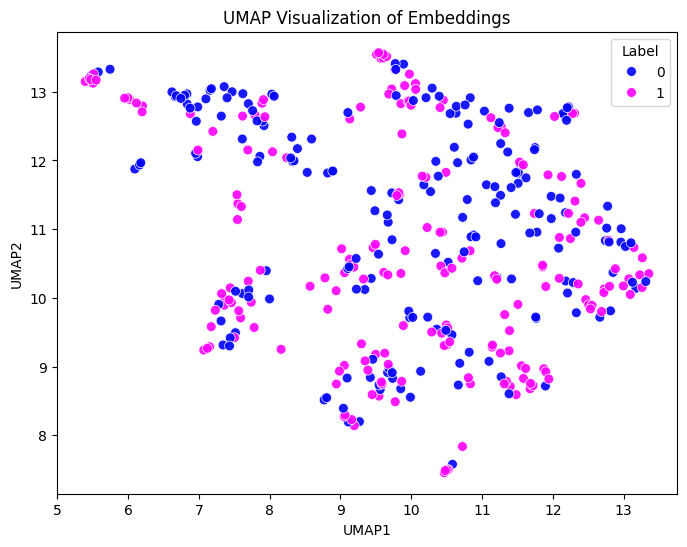

[I 2024-05-29 14:06:12,079] Trial 7 finished with values: [0.4250614643096924, 0.8025] and parameters: {'lr': 0.0012642228416175983, 'batch': 4, 'accum': 8, 'dropout_rate': 0.5203011342458395, 'weight_decay': 2.2559475400418825e-05, 'warmup_pct': 0.15045464954550575}. 


History:  [{'loss': 0.6558, 'learning_rate': 0.00021070380693626636, 'epoch': 1.0, 'step': 50}, {'eval_loss': 0.5854480266571045, 'eval_accuracy': 0.735, 'eval_runtime': 5.9157, 'eval_samples_per_second': 67.616, 'eval_steps_per_second': 8.452, 'epoch': 1.0, 'step': 50}, {'loss': 0.5284, 'learning_rate': 0.0004214076138725327, 'epoch': 2.0, 'step': 100}, {'eval_loss': 0.5302889943122864, 'eval_accuracy': 0.7375, 'eval_runtime': 5.4805, 'eval_samples_per_second': 72.986, 'eval_steps_per_second': 9.123, 'epoch': 2.0, 'step': 100}, {'loss': 0.4439, 'learning_rate': 0.0006321114208087991, 'epoch': 3.0, 'step': 150}, {'eval_loss': 0.4988511800765991, 'eval_accuracy': 0.78, 'eval_runtime': 5.4504, 'eval_samples_per_second': 73.389, 'eval_steps_per_second': 9.174, 'epoch': 3.0, 'step': 150}, {'loss': 0.4183, 'learning_rate': 0.0008428152277450654, 'epoch': 4.0, 'step': 200}, {'eval_loss': 0.4248508810997009, 'eval_accuracy': 0.8, 'eval_runtime': 5.4058, 'eval_samples_per_second': 73.994, 'eva

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.692200,0.676372,0.582500
2,0.658400,0.634624,0.717500
3,0.605000,0.588833,0.735000
4,0.550300,0.549953,0.752500
5,0.504300,0.525655,0.757500


Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Loaded best model from ./model_output/finetuned_model_ST.pth


{'eval_loss': 0.525654673576355, 'eval_accuracy': 0.7575, 'eval_runtime': 5.4248, 'eval_samples_per_second': 73.736, 'eval_steps_per_second': 9.217, 'epoch': 5.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 3, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 4, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 5, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 6, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 7, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 8, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 9, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 10, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 11, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 12, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 13, Second-to-Last Layer Embeddings Shape: (16, 1024)


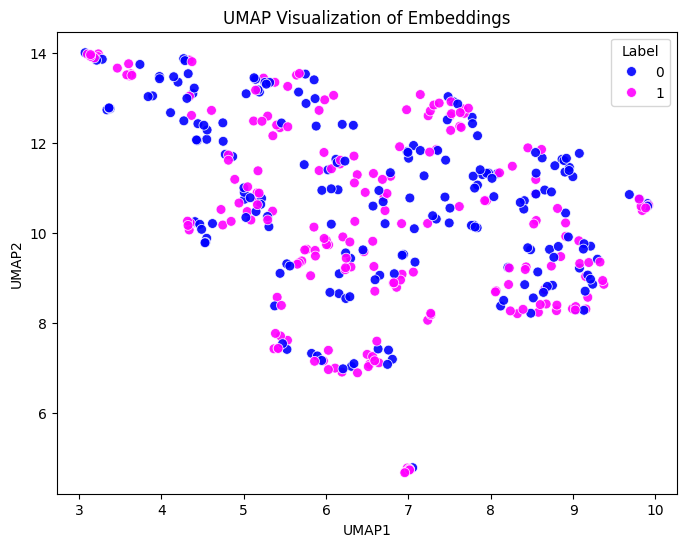

[I 2024-05-29 14:12:39,323] Trial 8 finished with values: [0.525654673576355, 0.7575] and parameters: {'lr': 0.00018879525538230234, 'batch': 4, 'accum': 8, 'dropout_rate': 0.28739601366072665, 'weight_decay': 0.0004342178213455746, 'warmup_pct': 0.29319379895796516}. 


History:  [{'loss': 0.6922, 'learning_rate': 1.610881018620327e-05, 'epoch': 1.0, 'step': 50}, {'eval_loss': 0.6763722896575928, 'eval_accuracy': 0.5825, 'eval_runtime': 5.9127, 'eval_samples_per_second': 67.651, 'eval_steps_per_second': 8.456, 'epoch': 1.0, 'step': 50}, {'loss': 0.6584, 'learning_rate': 3.221762037240654e-05, 'epoch': 2.0, 'step': 100}, {'eval_loss': 0.6346244812011719, 'eval_accuracy': 0.7175, 'eval_runtime': 5.4841, 'eval_samples_per_second': 72.938, 'eval_steps_per_second': 9.117, 'epoch': 2.0, 'step': 100}, {'loss': 0.605, 'learning_rate': 4.8326430558609807e-05, 'epoch': 3.0, 'step': 150}, {'eval_loss': 0.5888329148292542, 'eval_accuracy': 0.735, 'eval_runtime': 5.4629, 'eval_samples_per_second': 73.221, 'eval_steps_per_second': 9.153, 'epoch': 3.0, 'step': 150}, {'loss': 0.5503, 'learning_rate': 6.443524074481308e-05, 'epoch': 4.0, 'step': 200}, {'eval_loss': 0.5499529838562012, 'eval_accuracy': 0.7525, 'eval_runtime': 5.4267, 'eval_samples_per_second': 73.71, '

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.700000,0.689100,0.547500
2,0.690400,0.669938,0.622500
3,0.665000,0.643439,0.710000
4,0.634600,0.616127,0.722500
5,0.604600,0.592402,0.722500


Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Loaded best model from ./model_output/finetuned_model_ST.pth


{'eval_loss': 0.592401921749115, 'eval_accuracy': 0.7225, 'eval_runtime': 5.4159, 'eval_samples_per_second': 73.857, 'eval_steps_per_second': 9.232, 'epoch': 5.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 3, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 4, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 5, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 6, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 7, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 8, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 9, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 10, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 11, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 12, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 13, Second-to-Last Layer Embeddings Shape: (16, 1024)


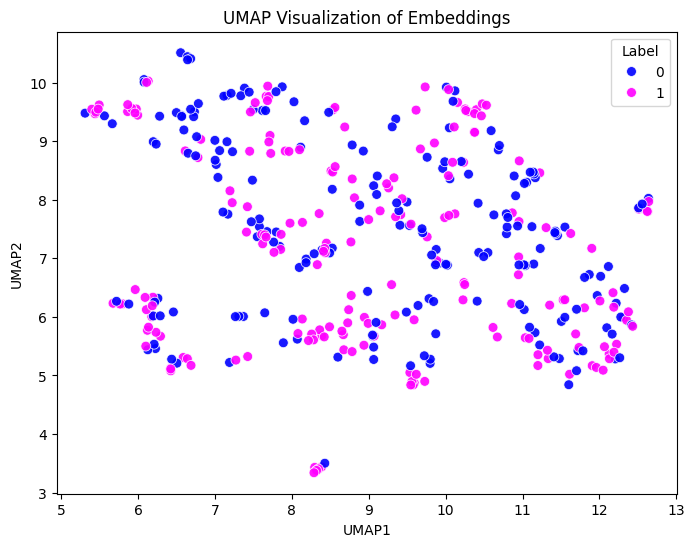

[I 2024-05-29 14:22:35,440] Trial 9 finished with values: [0.592401921749115, 0.7225] and parameters: {'lr': 2.5280012356488573e-05, 'batch': 2, 'accum': 4, 'dropout_rate': 0.6506571813092521, 'weight_decay': 0.00013143849512192553, 'warmup_pct': 0.23938128080604135}. 


History:  [{'loss': 0.7, 'learning_rate': 5.283179175859681e-06, 'epoch': 1.0, 'step': 200}, {'eval_loss': 0.6890996694564819, 'eval_accuracy': 0.5475, 'eval_runtime': 5.994, 'eval_samples_per_second': 66.734, 'eval_steps_per_second': 8.342, 'epoch': 1.0, 'step': 200}, {'loss': 0.6904, 'learning_rate': 1.0566358351719362e-05, 'epoch': 2.0, 'step': 400}, {'eval_loss': 0.6699380278587341, 'eval_accuracy': 0.6225, 'eval_runtime': 5.5414, 'eval_samples_per_second': 72.183, 'eval_steps_per_second': 9.023, 'epoch': 2.0, 'step': 400}, {'loss': 0.665, 'learning_rate': 1.5849537527579044e-05, 'epoch': 3.0, 'step': 600}, {'eval_loss': 0.6434393525123596, 'eval_accuracy': 0.71, 'eval_runtime': 5.459, 'eval_samples_per_second': 73.274, 'eval_steps_per_second': 9.159, 'epoch': 3.0, 'step': 600}, {'loss': 0.6346, 'learning_rate': 2.1132716703438724e-05, 'epoch': 4.0, 'step': 800}, {'eval_loss': 0.6161267757415771, 'eval_accuracy': 0.7225, 'eval_runtime': 5.5744, 'eval_samples_per_second': 71.757, 'e

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.729100,0.666894,0.662500
2,0.668100,0.612629,0.717500
3,0.639800,0.563704,0.737500
4,0.576800,0.515971,0.775000
5,0.516500,0.492350,0.785000


Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Loaded best model from ./model_output/finetuned_model_ST.pth


{'eval_loss': 0.4923495948314667, 'eval_accuracy': 0.785, 'eval_runtime': 5.4167, 'eval_samples_per_second': 73.846, 'eval_steps_per_second': 9.231, 'epoch': 5.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 3, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 4, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 5, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 6, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 7, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 8, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 9, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 10, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 11, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 12, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 13, Second-to-Last Layer Embeddings Shape: (16, 1024)


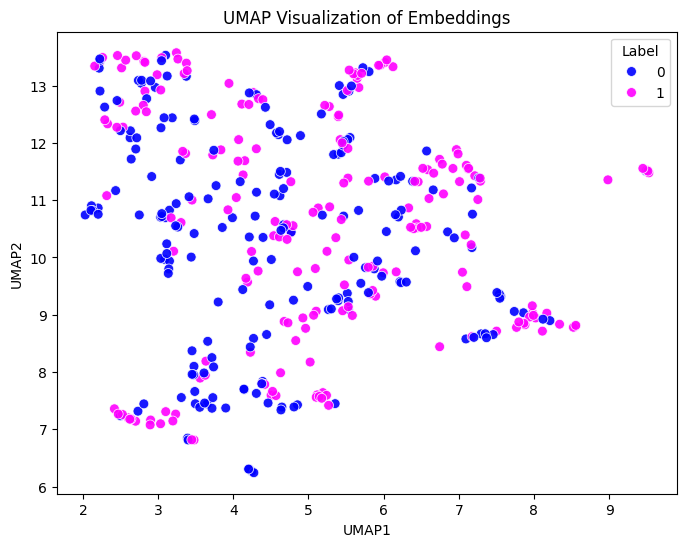

[I 2024-05-29 14:32:43,016] Trial 10 finished with values: [0.4923495948314667, 0.785] and parameters: {'lr': 0.0003728756326795037, 'batch': 2, 'accum': 8, 'dropout_rate': 0.8527304092210249, 'weight_decay': 8.94673398668428e-05, 'warmup_pct': 0.11472902508137751}. 


History:  [{'loss': 0.7291, 'learning_rate': 8.141389359814492e-05, 'epoch': 1.0, 'step': 100}, {'eval_loss': 0.6668941974639893, 'eval_accuracy': 0.6625, 'eval_runtime': 5.9496, 'eval_samples_per_second': 67.231, 'eval_steps_per_second': 8.404, 'epoch': 1.0, 'step': 100}, {'loss': 0.6681, 'learning_rate': 0.00016282778719628983, 'epoch': 2.0, 'step': 200}, {'eval_loss': 0.6126294136047363, 'eval_accuracy': 0.7175, 'eval_runtime': 5.5001, 'eval_samples_per_second': 72.726, 'eval_steps_per_second': 9.091, 'epoch': 2.0, 'step': 200}, {'loss': 0.6398, 'learning_rate': 0.00024424168079443474, 'epoch': 3.0, 'step': 300}, {'eval_loss': 0.5637044906616211, 'eval_accuracy': 0.7375, 'eval_runtime': 5.4128, 'eval_samples_per_second': 73.899, 'eval_steps_per_second': 9.237, 'epoch': 3.0, 'step': 300}, {'loss': 0.5768, 'learning_rate': 0.00032565557439257967, 'epoch': 4.0, 'step': 400}, {'eval_loss': 0.5159713625907898, 'eval_accuracy': 0.775, 'eval_runtime': 5.4288, 'eval_samples_per_second': 73.

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.594000,0.564893,0.757500
2,0.620300,0.626310,0.750000
3,0.491600,0.858840,0.797500
4,0.347700,0.746303,0.832500
5,0.170400,0.849316,0.840000


Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Loaded best model from ./model_output/finetuned_model_ST.pth


{'eval_loss': 0.8493158221244812, 'eval_accuracy': 0.84, 'eval_runtime': 5.422, 'eval_samples_per_second': 73.773, 'eval_steps_per_second': 9.222, 'epoch': 5.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 3, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 4, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 5, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 6, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 7, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 8, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 9, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 10, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 11, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 12, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 13, Second-to-Last Layer Embeddings Shape: (16, 1024)


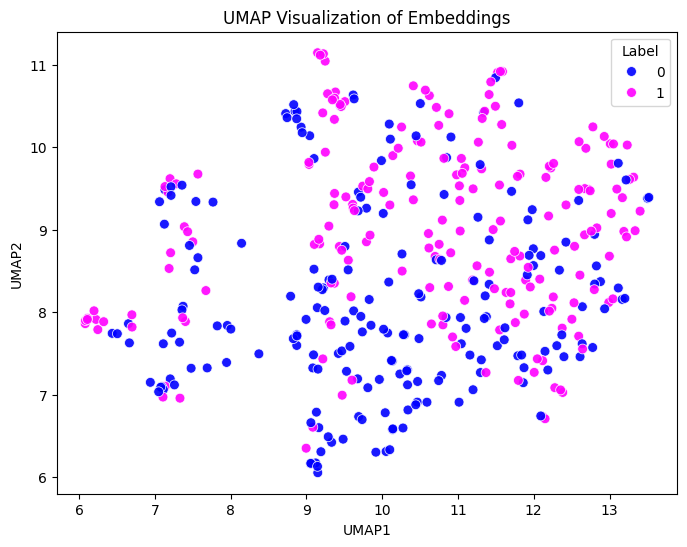

[I 2024-05-29 14:43:54,287] Trial 11 finished with values: [0.8493158221244812, 0.84] and parameters: {'lr': 0.0024599657137391855, 'batch': 2, 'accum': 2, 'dropout_rate': 0.10972788942948437, 'weight_decay': 0.0001706839835573477, 'warmup_pct': 0.14523232526557664}. 


History:  [{'loss': 0.594, 'learning_rate': 0.0016965280784408177, 'epoch': 1.0, 'step': 400}, {'eval_loss': 0.5648930072784424, 'eval_accuracy': 0.7575, 'eval_runtime': 5.9396, 'eval_samples_per_second': 67.344, 'eval_steps_per_second': 8.418, 'epoch': 1.0, 'step': 400}, {'loss': 0.6203, 'learning_rate': 0.002078844265131706, 'epoch': 2.0, 'step': 800}, {'eval_loss': 0.626309871673584, 'eval_accuracy': 0.75, 'eval_runtime': 5.5161, 'eval_samples_per_second': 72.516, 'eval_steps_per_second': 9.064, 'epoch': 2.0, 'step': 800}, {'loss': 0.4916, 'learning_rate': 0.0013858961767544708, 'epoch': 3.0, 'step': 1200}, {'eval_loss': 0.8588402271270752, 'eval_accuracy': 0.7975, 'eval_runtime': 5.4186, 'eval_samples_per_second': 73.82, 'eval_steps_per_second': 9.227, 'epoch': 3.0, 'step': 1200}, {'loss': 0.3477, 'learning_rate': 0.0006929480883772354, 'epoch': 4.0, 'step': 1600}, {'eval_loss': 0.746303379535675, 'eval_accuracy': 0.8325, 'eval_runtime': 5.4195, 'eval_samples_per_second': 73.807, '

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.710500,0.692896,0.505000
2,0.700600,0.681285,0.560000
3,0.677900,0.664422,0.642500
4,0.662300,0.644987,0.692500
5,0.642400,0.625373,0.725000


Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Loaded best model from ./model_output/finetuned_model_ST.pth


{'eval_loss': 0.6253732442855835, 'eval_accuracy': 0.725, 'eval_runtime': 5.4515, 'eval_samples_per_second': 73.374, 'eval_steps_per_second': 9.172, 'epoch': 5.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 3, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 4, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 5, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 6, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 7, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 8, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 9, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 10, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 11, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 12, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 13, Second-to-Last Layer Embeddings Shape: (16, 1024)


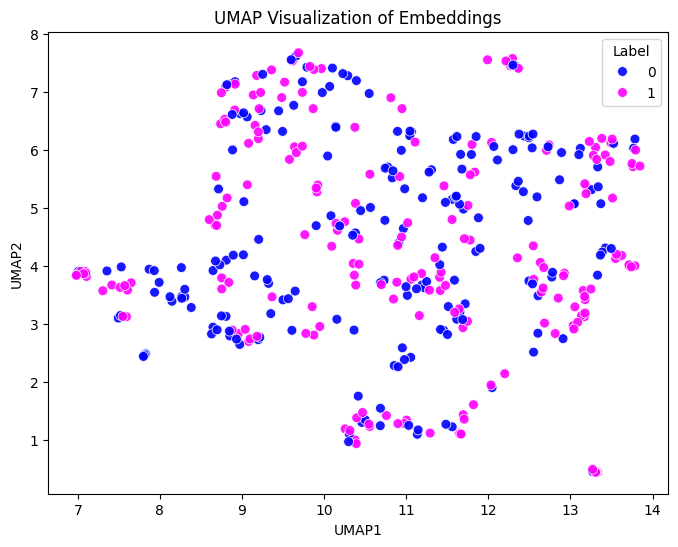

[I 2024-05-29 14:51:40,267] Trial 12 finished with values: [0.6253732442855835, 0.725] and parameters: {'lr': 6.288048293580854e-05, 'batch': 8, 'accum': 8, 'dropout_rate': 0.6623565678905602, 'weight_decay': 0.0008954396999547348, 'warmup_pct': 0.1777792588516075}. 


History:  [{'loss': 0.7105, 'learning_rate': 8.881424143475782e-06, 'epoch': 1.0, 'step': 25}, {'eval_loss': 0.6928958296775818, 'eval_accuracy': 0.505, 'eval_runtime': 5.9861, 'eval_samples_per_second': 66.822, 'eval_steps_per_second': 8.353, 'epoch': 1.0, 'step': 25}, {'loss': 0.7006, 'learning_rate': 1.7762848286951564e-05, 'epoch': 2.0, 'step': 50}, {'eval_loss': 0.6812852621078491, 'eval_accuracy': 0.56, 'eval_runtime': 5.4888, 'eval_samples_per_second': 72.876, 'eval_steps_per_second': 9.11, 'epoch': 2.0, 'step': 50}, {'loss': 0.6779, 'learning_rate': 2.6644272430427346e-05, 'epoch': 3.0, 'step': 75}, {'eval_loss': 0.664421796798706, 'eval_accuracy': 0.6425, 'eval_runtime': 5.4525, 'eval_samples_per_second': 73.36, 'eval_steps_per_second': 9.17, 'epoch': 3.0, 'step': 75}, {'loss': 0.6623, 'learning_rate': 3.552569657390313e-05, 'epoch': 4.0, 'step': 100}, {'eval_loss': 0.6449865698814392, 'eval_accuracy': 0.6925, 'eval_runtime': 5.4456, 'eval_samples_per_second': 73.454, 'eval_st

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.691400,0.659586,0.655000
2,0.625700,0.594618,0.737500
3,0.546100,0.539647,0.742500
4,0.487200,0.501463,0.757500
5,0.454100,0.470617,0.780000


Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Loaded best model from ./model_output/finetuned_model_ST.pth


{'eval_loss': 0.47061678767204285, 'eval_accuracy': 0.78, 'eval_runtime': 5.4125, 'eval_samples_per_second': 73.903, 'eval_steps_per_second': 9.238, 'epoch': 5.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 3, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 4, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 5, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 6, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 7, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 8, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 9, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 10, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 11, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 12, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 13, Second-to-Last Layer Embeddings Shape: (16, 1024)


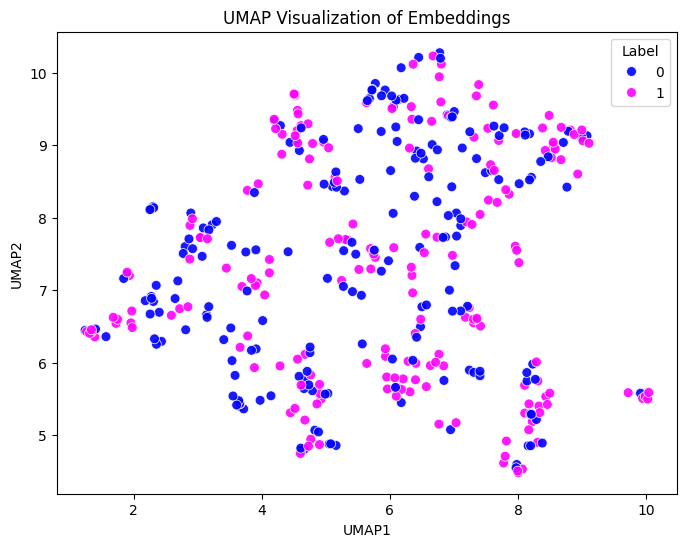

[I 2024-05-29 15:02:09,023] Trial 13 finished with values: [0.47061678767204285, 0.78] and parameters: {'lr': 0.00022124803301278606, 'batch': 8, 'accum': 4, 'dropout_rate': 0.4784033498406014, 'weight_decay': 0.00045960434305305505, 'warmup_pct': 0.2537666907748476}. 


History:  [{'loss': 0.6914, 'learning_rate': 4.372490771003677e-05, 'epoch': 1.0, 'step': 50}, {'eval_loss': 0.6595855951309204, 'eval_accuracy': 0.655, 'eval_runtime': 5.9255, 'eval_samples_per_second': 67.504, 'eval_steps_per_second': 8.438, 'epoch': 1.0, 'step': 50}, {'loss': 0.6257, 'learning_rate': 8.744981542007354e-05, 'epoch': 2.0, 'step': 100}, {'eval_loss': 0.5946183204650879, 'eval_accuracy': 0.7375, 'eval_runtime': 5.5117, 'eval_samples_per_second': 72.573, 'eval_steps_per_second': 9.072, 'epoch': 2.0, 'step': 100}, {'loss': 0.5461, 'learning_rate': 0.0001311747231301103, 'epoch': 3.0, 'step': 150}, {'eval_loss': 0.5396469831466675, 'eval_accuracy': 0.7425, 'eval_runtime': 5.4103, 'eval_samples_per_second': 73.933, 'eval_steps_per_second': 9.242, 'epoch': 3.0, 'step': 150}, {'loss': 0.4872, 'learning_rate': 0.00017489963084014708, 'epoch': 4.0, 'step': 200}, {'eval_loss': 0.5014630556106567, 'eval_accuracy': 0.7575, 'eval_runtime': 5.4098, 'eval_samples_per_second': 73.94, 

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.632200,0.558490,0.730000
2,0.490000,0.521953,0.747500
3,0.405600,0.512923,0.777500
4,0.364200,0.475791,0.795000
5,0.320500,0.484968,0.797500


Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Loaded best model from ./model_output/finetuned_model_ST.pth


{'eval_loss': 0.4849678874015808, 'eval_accuracy': 0.7975, 'eval_runtime': 5.4246, 'eval_samples_per_second': 73.738, 'eval_steps_per_second': 9.217, 'epoch': 5.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 3, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 4, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 5, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 6, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 7, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 8, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 9, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 10, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 11, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 12, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 13, Second-to-Last Layer Embeddings Shape: (16, 1024)


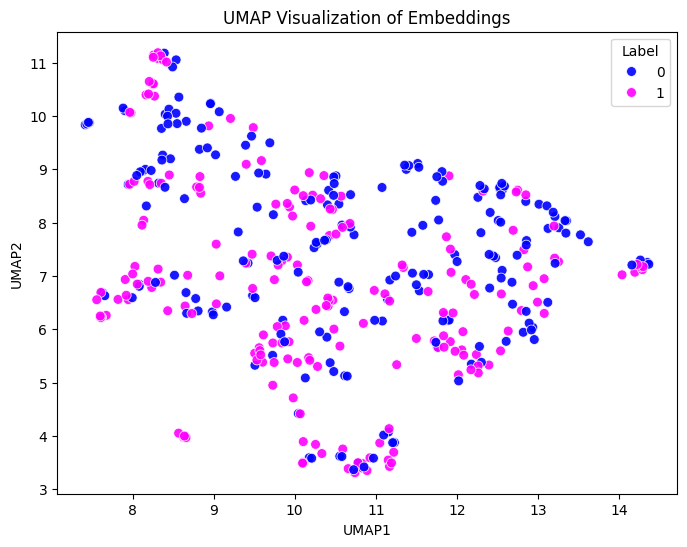

[I 2024-05-29 15:20:15,394] Trial 14 finished with values: [0.4849678874015808, 0.7975] and parameters: {'lr': 0.0001759856197307432, 'batch': 4, 'accum': 2, 'dropout_rate': 0.24149039269351125, 'weight_decay': 0.0006537378516583614, 'warmup_pct': 0.17828544287064532}. 


History:  [{'loss': 0.6322, 'learning_rate': 9.886832569142877e-05, 'epoch': 1.0, 'step': 200}, {'eval_loss': 0.5584896206855774, 'eval_accuracy': 0.73, 'eval_runtime': 5.9272, 'eval_samples_per_second': 67.486, 'eval_steps_per_second': 8.436, 'epoch': 1.0, 'step': 200}, {'loss': 0.49, 'learning_rate': 0.00016396175751311477, 'epoch': 2.0, 'step': 400}, {'eval_loss': 0.5219529867172241, 'eval_accuracy': 0.7475, 'eval_runtime': 5.5599, 'eval_samples_per_second': 71.943, 'eval_steps_per_second': 8.993, 'epoch': 2.0, 'step': 400}, {'loss': 0.4056, 'learning_rate': 0.00010930783834207652, 'epoch': 3.0, 'step': 600}, {'eval_loss': 0.5129225850105286, 'eval_accuracy': 0.7775, 'eval_runtime': 5.419, 'eval_samples_per_second': 73.815, 'eval_steps_per_second': 9.227, 'epoch': 3.0, 'step': 600}, {'loss': 0.3642, 'learning_rate': 5.465391917103826e-05, 'epoch': 4.0, 'step': 800}, {'eval_loss': 0.47579053044319153, 'eval_accuracy': 0.795, 'eval_runtime': 5.4235, 'eval_samples_per_second': 73.753, 

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.676800,0.582526,0.722500
2,0.589900,0.546395,0.740000
3,0.558000,0.558523,0.775000
4,0.539800,0.569536,0.775000
5,0.516600,0.573466,0.772500


Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Saved improved model to ./model_output/finetuned_model_ST.pth
Loaded best model from ./model_output/finetuned_model_ST.pth


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5585228204727173, 'eval_accuracy': 0.775, 'eval_runtime': 5.4615, 'eval_samples_per_second': 73.239, 'eval_steps_per_second': 9.155, 'epoch': 5.0}
Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 3, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 4, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 5, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 6, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 7, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 8, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 9, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 10, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 11, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 12, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 13, Second-to-Last Layer Embeddings S

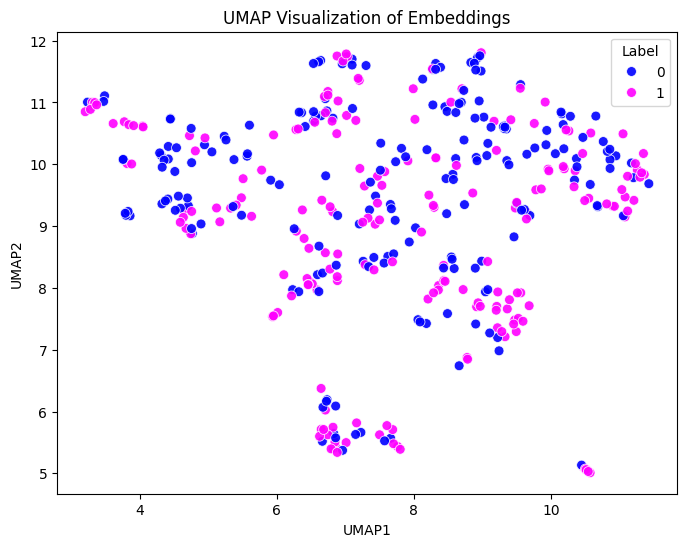

[I 2024-05-29 15:53:06,029] Trial 15 finished with values: [0.5585228204727173, 0.775] and parameters: {'lr': 0.00015364299703497645, 'batch': 2, 'accum': 2, 'dropout_rate': 0.8403463316563824, 'weight_decay': 0.00013099738398048125, 'warmup_pct': 0.05393273286922582}. 


History:  [{'loss': 0.6768, 'learning_rate': 0.00013771921302855033, 'epoch': 1.0, 'step': 400}, {'eval_loss': 0.582526445388794, 'eval_accuracy': 0.7225, 'eval_runtime': 5.9431, 'eval_samples_per_second': 67.305, 'eval_steps_per_second': 8.413, 'epoch': 1.0, 'step': 400}, {'loss': 0.5899, 'learning_rate': 0.00010328940977141274, 'epoch': 2.0, 'step': 800}, {'eval_loss': 0.5463950037956238, 'eval_accuracy': 0.74, 'eval_runtime': 5.4998, 'eval_samples_per_second': 72.73, 'eval_steps_per_second': 9.091, 'epoch': 2.0, 'step': 800}, {'loss': 0.558, 'learning_rate': 6.885960651427516e-05, 'epoch': 3.0, 'step': 1200}, {'eval_loss': 0.5585228204727173, 'eval_accuracy': 0.775, 'eval_runtime': 5.4239, 'eval_samples_per_second': 73.748, 'eval_steps_per_second': 9.218, 'epoch': 3.0, 'step': 1200}, {'loss': 0.5398, 'learning_rate': 3.442980325713758e-05, 'epoch': 4.0, 'step': 1600}, {'eval_loss': 0.5695361495018005, 'eval_accuracy': 0.775, 'eval_runtime': 5.434, 'eval_samples_per_second': 73.611, 

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



[W 2024-05-29 15:55:42,396] Trial 16 failed with parameters: {'lr': 0.005584904829826275, 'batch': 2, 'accum': 4, 'dropout_rate': 0.8614479740889428, 'weight_decay': 0.000764573271063838, 'warmup_pct': 0.20090129074017674} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_10685/23857210.py", line 16, in objective
    tokenizer, model, history = train_per_protein(
  File "/tmp/ipykernel_10685/1805120109.py", line 76, in train_per_protein
    train_set=create_dataset(tokenizer,list(train_df['sequence']),list(train_df['label']))
  File "/tmp/ipykernel_10685/1805120109.py", line 14, in create_dataset
    tokenized = tokenizer(seqs, max_length=1024, padding=True, truncation=True)
  File "/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packag

KeyboardInterrupt: 

In [19]:
import optuna

def objective(trial):
    # Hyperparameters to be optimized
    # Updated to use suggest_float with log=True for loguniform distribution
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch = trial.suggest_categorical('batch', [1, 2, 4, 8])
    accum = trial.suggest_categorical('accum', [2, 4, 8])
    # Updated to use suggest_float for uniform distribution
    dropout = trial.suggest_float('dropout_rate', 0.1, 0.9)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    warmup_pct = trial.suggest_float("warmup_pct", 0.01, 0.3)  # Warmup percentage between 1% and 30%


    # Training and evaluation
    tokenizer, model, history = train_per_protein(
        train_df=my_train, 
        valid_df=my_valid, 
        num_labels=2, 
        batch=batch, 
        accum=accum, 
        epochs=5,  # Fewer epochs for the trial runs
        lr=lr,
        dropout=dropout,
        weight_decay=weight_decay,
        warmup_pct=warmup_pct,
    )
    
    # Clear GPU memory
    torch.cuda.empty_cache()
    
    print("History: ", history)
    
    # Extract the last validation accuracy from the history
    val_accuracy = [entry['eval_accuracy'] for entry in history if 'eval_accuracy' in entry][-1]
    val_loss = [entry['eval_loss'] for entry in history if 'eval_loss' in entry][-1]
    return val_loss, val_accuracy

directions=['minimize', 'maximize']  # Set the direction to maximize the validation accuracy, can also be 'minimize'
study = optuna.create_study(directions=directions,
                            storage="sqlite:///all_dephos.sqlite3",  # Specify the storage URL here.
                            study_name="all_dephos")
study.optimize(objective, n_trials=20)  # Adjust the number of trials based on your computational resources

# Analyzing results
pareto_front = study.best_trials  # Get the Pareto front (best non-dominated solutions)
for trial in pareto_front:
    print(f"Loss: {trial.values[0]}, Accuracy: {trial.values[1]}")  # Note the negation of accuracy

# print("Best trial:")
# print("  Value: ", study.best_trial.value)
# print("  Params: ")
# for key, value in study.best_trial.params.items():
#     print(f"    {key}: {value}")


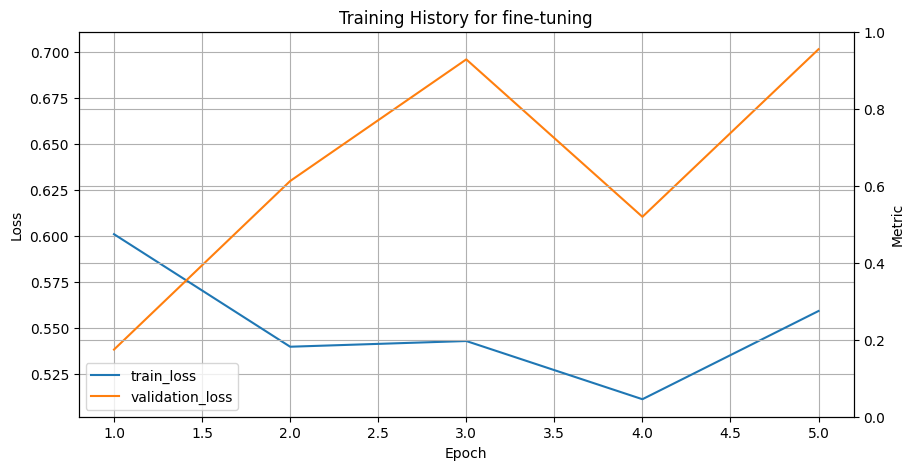

In [13]:
# Get loss, val_loss, and the computed metric from history
loss = [x['loss'] for x in history if 'loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

# Truncate the longer list to the size of the shorter one
min_length = min(len(loss), len(val_loss))
loss = loss[:min_length]
val_loss = val_loss[:min_length]

# Get spearman (for regression) or accuracy value (for classification)
if [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x] != []:
    metric = [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x]
else:
    metric = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]

epochs = [x['epoch'] for x in history if 'loss' in x]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot loss and val_loss on the first y-axis
line1 = ax1.plot(epochs, loss, label='train_loss')
line2 = ax1.plot(epochs, val_loss, label='validation_loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot the computed metric on the second y-axis
#line3 = ax2.plot(epochs, metric, color='red', label='validation_metric')
ax2.set_ylabel('Metric')
ax2.set_ylim([0, 1])

# Add grid lines
ax1.grid(True)
ax2.grid(True)

# Combine the lines from both y-axes and create a single legend
lines = line1 + line2 
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')

# Show the plot
plt.title("Training History for fine-tuning")
plt.savefig(f"../Plots/Without_3rdline_Training_History_new.pdf")
plt.show()

In [11]:
def save_model(model,filepath):
# Saves all parameters that were changed during finetuning

    # Create a dictionary to hold the non-frozen parameters
    non_frozen_params = {}

    # Iterate through all the model parameters
    for param_name, param in model.named_parameters():
        # If the parameter has requires_grad=True, add it to the dictionary
        if param.requires_grad:
            non_frozen_params[param_name] = param

    # Save only the finetuned parameters 
    torch.save(non_frozen_params, filepath)

    
def load_model(filepath, num_labels=2):
# Creates a new PT5 model and loads the finetuned weights from a file

    # load a new model
    model, tokenizer = PT5_classification_model(num_labels=num_labels, dropout=0.10972788942948437)
    
    # Load the non-frozen parameters from the saved file
    non_frozen_params = torch.load(filepath)

    # Assign the non-frozen parameters to the corresponding parameters of the model
    for param_name, param in model.named_parameters():
        if param_name in non_frozen_params:
            param.data = non_frozen_params[param_name].data

    return tokenizer, model

In [ ]:
# def save_model(model, filepath):
#     torch.save(model.state_dict(), filepath)

# save_model(model, "../finetuned_model.pth")

In [12]:
# tokenizer, model_reload = load_model("../finetuned_model.pth", num_labels=2)
tokenizer, model_reload = load_model("model_output/finetuned_model_ST.pth",num_labels=2)

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



In [14]:
# Put both models to the same device
model=model.to("cpu")
model_reload=model_reload.to("cpu")

# Iterate through the parameters of the two models and compare the data
for param1, param2 in zip(model.parameters(), model_reload.parameters()):
    if not torch.equal(param1.data, param2.data):
        print("Models have different weights")
        break
else:
    print("Models have identical weights")

NameError: name 'model' is not defined

In [ ]:
# model = from_pretrained("model_output")

In [15]:
from Bio import SeqIO
import pandas as pd

sequences = []

local_fasta_path = '../src/input_datasets/test_Pos_Neg_ST.fasta'

# Load FASTA file using Biopython
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])
    
local_fasta_path = '../src/input_datasets/test_Pos_Neg_Y.fasta'

# Load FASTA file using Biopython
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df.head(5)


,name,sequence,label
0,sp|Q8WUI4|HDAC7_HUMAN%342%358,ERLSGSGLHWPLSRTRSEPLPPSATAPPPPGPM,1
1,sp|Q13950|RUNX2_HUMAN%416%432,THYHTYLPPPYPGSSQSQSGPFQTSSTPYLYYG,1
2,sp|Q15796|SMAD2_HUMAN%229%245,DGETSDQQLNQSMDTGSPAELSPTTLSPVNHSL,1
3,sp|P05787|K2C8_HUMAN%416%432,TSGYAGGLSSAYGGLTSPGLSYSLGSSFGSGAG,1
4,sp|Q92736|RYR2_HUMAN%2798%2814,MALYNRTRRISQTSQVSVDAAHGYSPRAIDMSN,1


In [16]:
my_test=df[["sequence", "label"]]

print(my_test.head(5))

'''
my_test["sequence"]=my_test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
my_test['sequence']=my_test.apply(lambda row : " ".join(row["sequence"]), axis = 1)
'''

#Using .loc ensures that you are modifying the original DataFrame rather than a view of it, which helps avoid the SettingWithCopyWarning.
# Replace characters in the "sequence" column
my_test.loc[:, "sequence"] = my_test["sequence"].str.replace('|'.join(["O", "B", "U", "Z"]), "X", regex=True)

# Convert each sequence to a space-separated string
my_test.loc[:, 'sequence'] = my_test.apply(lambda row: " ".join(row["sequence"]), axis=1)


                            sequence  label
0  ERLSGSGLHWPLSRTRSEPLPPSATAPPPPGPM      1
1  THYHTYLPPPYPGSSQSQSGPFQTSSTPYLYYG      1
2  DGETSDQQLNQSMDTGSPAELSPTTLSPVNHSL      1
3  TSGYAGGLSSAYGGLTSPGLSYSLGSSFGSGAG      1
4  MALYNRTRRISQTSQVSVDAAHGYSPRAIDMSN      1


In [21]:
# Function to get the middle character
def get_middle_char(sequence):
    chars = sequence.split()
    middle_index = len(chars) // 2
    return chars[middle_index]

# Apply the function to get the middle characters
my_test['middle_char'] = my_test['sequence'].apply(get_middle_char)

# Split the DataFrame
my_test_S = my_test[my_test['middle_char'] == 'S'].drop(columns=['middle_char'])
my_test_T = my_test[my_test['middle_char'] == 'T'].drop(columns=['middle_char'])
my_test_Y = my_test[my_test['middle_char'] == 'Y'].drop(columns=['middle_char'])
my_test_ST = my_test[my_test['middle_char'].isin(['S', 'T'])].drop(columns=['middle_char'])

In [40]:
# Apply the function to get the middle characters
my_train['middle_char'] = my_train['sequence'].apply(get_middle_char)

# Split the DataFrame
my_train_S = my_train[my_train['middle_char'] == 'S'].drop(columns=['middle_char'])
my_train_T = my_train[my_train['middle_char'] == 'T'].drop(columns=['middle_char'])
my_train_Y = my_train[my_train['middle_char'] == 'Y'].drop(columns=['middle_char'])

In [49]:
my_test_S[my_test_S['label'] == 0]

,sequence,label
222,T V A V P T V A A F P N T S S T S V P T S P E ...,0
223,G L D F H R F Y F E N L W S R N S K P V H T T ...,0
224,T M S G E A S A P L P I R Q P N S G P Y K K Q ...,0
225,M S P E R E M G N E N I P S T V S T I S R N N ...,0
226,C T D F D N I L M T V T C F E K S E Q V Q G A ...,0
...,...,...
398,A T S P Q S P L M Q C S F Y N R S S P V H I I ...,0
399,R A A S Q I N V C G V R K R S Y S A G N A S Q ...,0
400,T A E E N L C C E E L S S K I M S S L E D E G ...,0
401,D S V L G A G A C G G V P I I F S R N S G L V ...,0


In [26]:
my_test = my_test_ST

In [27]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_auc_score
from tabulate import tabulate

# Set the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_reload.to(device)

# create Dataset
test_set=create_dataset(tokenizer,list(my_test['sequence']),list(my_test['label']))
# make compatible with torch DataLoader
test_set = test_set.with_format("torch", device=device)

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model_reload.eval()

# Make predictions on the test dataset
raw_logits = []
labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # add batch results (logits) to predictions
        raw_logits += model_reload(input_ids, attention_mask=attention_mask).logits.tolist()
        labels += batch["labels"].tolist()

# Convert logits to predictions
raw_logits = np.array(raw_logits)
predictions = np.argmax(raw_logits, axis=1)

# Calculate metrics
conf_matrix = confusion_matrix(labels, predictions)
tn, fp, fn, tp = conf_matrix.ravel()

mcc = matthews_corrcoef(labels, predictions)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy = accuracy_score(labels, predictions)
roc_auc = roc_auc_score(labels, raw_logits[:, 1])  # Assuming binary classification, adjust accordingly


metrics_table = [
    ["MCC", "Specificity", "Sensitivity", "Accuracy", "ROC-AUC"],
    [mcc, specificity, sensitivity, accuracy, roc_auc]
]

print(tabulate(metrics_table, headers="firstrow", tablefmt="grid"))
print(conf_matrix)


  0%|                                                                       | 0/28 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████| 28/28 [00:04<00:00,  6.68it/s]

+----------+---------------+---------------+------------+-----------+
|      MCC |   Specificity |   Sensitivity |   Accuracy |   ROC-AUC |
+==========+===============+===============+============+===========+
| 0.597173 |      0.825893 |       0.77027 |   0.798206 |  0.867077 |
+----------+---------------+---------------+------------+-----------+
[[185  39]
 [ 51 171]]


In [24]:
my_test = my_test_Y

In [25]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_auc_score
from tabulate import tabulate

# Set the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_reload.to(device)

# create Dataset
test_set=create_dataset(tokenizer,list(my_test['sequence']),list(my_test['label']))
# make compatible with torch DataLoader
test_set = test_set.with_format("torch", device=device)

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model_reload.eval()

# Make predictions on the test dataset
raw_logits = []
labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # add batch results (logits) to predictions
        raw_logits += model_reload(input_ids, attention_mask=attention_mask).logits.tolist()
        labels += batch["labels"].tolist()

# Convert logits to predictions
raw_logits = np.array(raw_logits)
predictions = np.argmax(raw_logits, axis=1)

# Calculate metrics
conf_matrix = confusion_matrix(labels, predictions)
tn, fp, fn, tp = conf_matrix.ravel()

mcc = matthews_corrcoef(labels, predictions)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy = accuracy_score(labels, predictions)
roc_auc = roc_auc_score(labels, raw_logits[:, 1])  # Assuming binary classification, adjust accordingly


metrics_table = [
    ["MCC", "Specificity", "Sensitivity", "Accuracy", "ROC-AUC"],
    [mcc, specificity, sensitivity, accuracy, roc_auc]
]

print(tabulate(metrics_table, headers="firstrow", tablefmt="grid"))
print(conf_matrix)


100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.12it/s]

+----------+---------------+---------------+------------+-----------+
|      MCC |   Specificity |   Sensitivity |   Accuracy |   ROC-AUC |
+==========+===============+===============+============+===========+
| 0.851631 |      0.846154 |             1 |       0.92 |  0.971154 |
+----------+---------------+---------------+------------+-----------+
[[22  4]
 [ 0 24]]


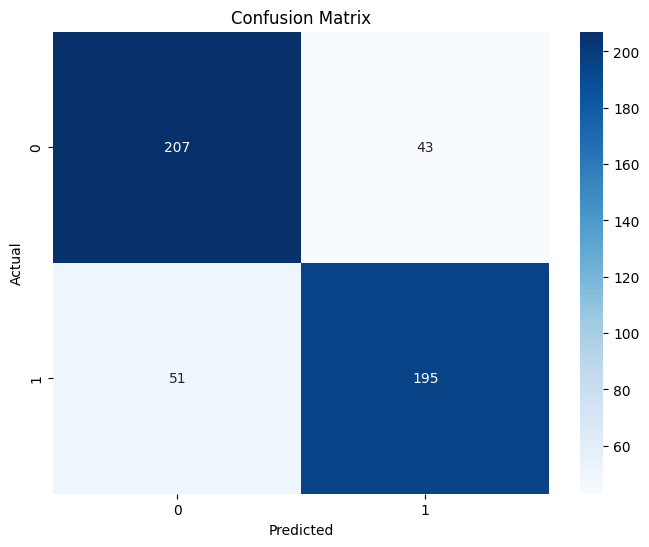

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define class labels
class_labels = ['0', '1']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(f"../Plots/Confusion_matrix_for_dephos_new.pdf")
plt.show()


In [20]:
import umap

def apply_umap(embeddings, n_components=2, n_neighbors=5, min_dist=0.01, metric='euclidean'):
    umap_model = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric
    )
    umap_embeddings = umap_model.fit_transform(embeddings)
    return umap_embeddings

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_umap(embeddings, labels):
    df = pd.DataFrame({
        "UMAP1": embeddings[:, 0],
        "UMAP2": embeddings[:, 1],
        "Label": labels
    })
    plt.figure(figsize=(10, 8))
    scatter = sns.scatterplot(
        x="UMAP1", y="UMAP2", hue="Label", data=df, palette={0: "blue", 1: "magenta"}, s=50, alpha=0.9
    )
    plt.title("UMAP Visualization of Embeddings")
    plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc=2)
    plt.savefig("../Plots/UMAP_Visualization_of_Embeddings_ST.pdf", bbox_inches='tight')
    plt.show()
    
def get_embeddings(model, tokenizer, sequences, batch_size=32, device="cuda"):
    embeddings = []
    model = model.to(device)
    model.eval()

    for i in range(0, len(sequences), batch_size):
        batch = sequences[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            hidden_states = outputs.hidden_states[-2].detach().cpu().numpy()
            embeddings.extend(hidden_states[:, 0, :])

        print(f"Processed batch {i // batch_size + 1}/{len(sequences) // batch_size + 1}")

    return np.array(embeddings)

In [38]:
# Function to get the middle character
def get_middle_char(sequence):
    chars = list(sequence)
    middle_index = len(chars) // 2
    return chars[middle_index]

valid_df = df

# Apply the function to get the middle characters
valid_df['middle_char'] = valid_df['sequence'].apply(get_middle_char)

valid_df = valid_df[valid_df['middle_char'] == 'T'].drop(columns=['middle_char'])

In [39]:
valid_df

,name,sequence,label
180,sp|Q9GZM8|NDEL1_HUMAN%203%219,CEKMDSAVQASLSLPATPVGKGTENTFPSPKAI,1
181,sp|Q8N163|CCAR2_HUMAN%438%454,EWEALCQQKAAEAAPPTQEAQGETEPTEQAPDA,1
182,sp|P10636-8|TAU_HUMAN%196%212,GYSSPGSPGTPGSRSRTPSLPTPPTREPKKVAV,1
183,sp|Q02241|KIF23_HUMAN%434%450,QEVEVARPVDKAICGLTPGRRYRNQPRGPVGNE,1
184,sp|Q04206|TF65_HUMAN%419%435,QAVAPPAPKPTQAGEGTLSEALLQLQFDDEDLG,1
...,...,...,...
441,sp|Q76N33|STALP_MOUSE%326%342,ENVEELFNVQDQHGLLTLGWIHTHPTQTAFLSS,0
442,sp|P49790|NU153_HUMAN%1098%1114,FVLGRTEEKQQEPVTSTSLVFGKKADNEEPKCQ,0
443,sp|Q8NFC6|BD1L1_HUMAN%2789%2805,DVLDSRIETAQRQCPETEPHDTKEENSRDLEEL,0
444,sp|Q5T6F2|UBAP2_HUMAN%514%530,SKIPASAVEMPGSADVTGLNVQFGALEFGSEPS,0


/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0

Processed batch 1/3
Processed batch 2/3
Processed batch 3/3


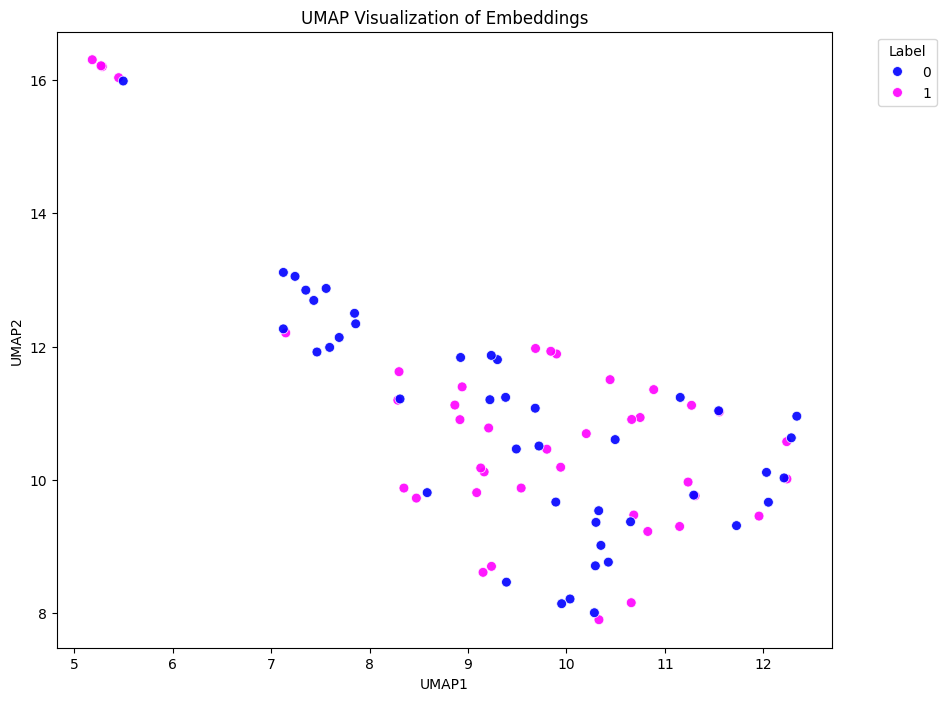

In [40]:
# valid_df = my_valid

# tokenizer, model_reload = load_model("../finetuned_model.pth", num_labels=2)
tokenizer, model_reload = load_model("model_output/finetuned_model_ST.pth",num_labels=2)

valid_df["sequence"] = valid_df["sequence"].str.replace('|'.join(["O", "B", "U", "Z"]), "X", regex=True)
valid_df["sequence"] = valid_df["sequence"].apply(lambda x: " ".join(x))

valid_sequences = list(valid_df['sequence'])
valid_embeddings = get_embeddings(model_reload, tokenizer, valid_sequences)

umap_embeddings = apply_umap(valid_embeddings)


labels = list(valid_df['label'])

plot_umap(umap_embeddings, labels)
